In [192]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.filters.hp_filter import hpfilter
from scipy.stats import linregress
from statsmodels.tsa.arima.model import ARIMA
from pyts.decomposition import SingularSpectrumAnalysis
from pmdarima.arima import auto_arima
import warnings
import itertools
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.signal import periodogram, find_peaks
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr
from rpy2.robjects.conversion import localconverter
import rpy2.robjects as ro
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats import boxcox, normaltest
from scipy.stats.mstats import winsorize
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt
import pywt
from sklearn.decomposition import PCA
from numpy.lib.stride_tricks import sliding_window_view
from sklearn.utils.extmath import randomized_svd
from PyEMD import EMD
from sklearn.cluster import KMeans
from scipy.stats import skew, kurtosis
from pykalman import KalmanFilter
import torch
import torch.nn as nn
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from astropy.timeseries import LombScargle
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import seaborn as sns
from sklearn.preprocessing import normalize
from sklearn.mixture import GaussianMixture
from scipy.stats import ttest_ind
import datetime
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
from scipy.signal import correlate
from scipy.fft import fft, fftfreq
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
from collections import Counter
from sklearn.cluster import DBSCAN
import requests
from io import StringIO
from scipy.stats import spearmanr
from sklearn.metrics import mutual_info_score
from statsmodels.tsa.stattools import grangercausalitytests
from pyinform.transferentropy import transfer_entropy
from tigramite.data_processing import DataFrame as TDF
from tigramite.pcmci import PCMCI
import pyinform
import pyEDM


# Подавляем только FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
time_series = pd.read_excel("bitcoin.xlsx")

In [4]:
time_series = time_series.sort_values('Дата', ignore_index=True)
time_series

Дата       Значение
0    2015-05-06     229.780000
1    2015-05-07     237.330000
2    2015-05-08     243.860000
3    2015-05-09     241.830000
4    2015-05-10     240.300000
...         ...            ...
3607 2025-05-30  104694.787188
3608 2025-05-31  103803.121799
3609 2025-06-01  105233.374133
3610 2025-06-02  104839.027304
3611 2025-06-03  105927.194148

[3612 rows x 2 columns]

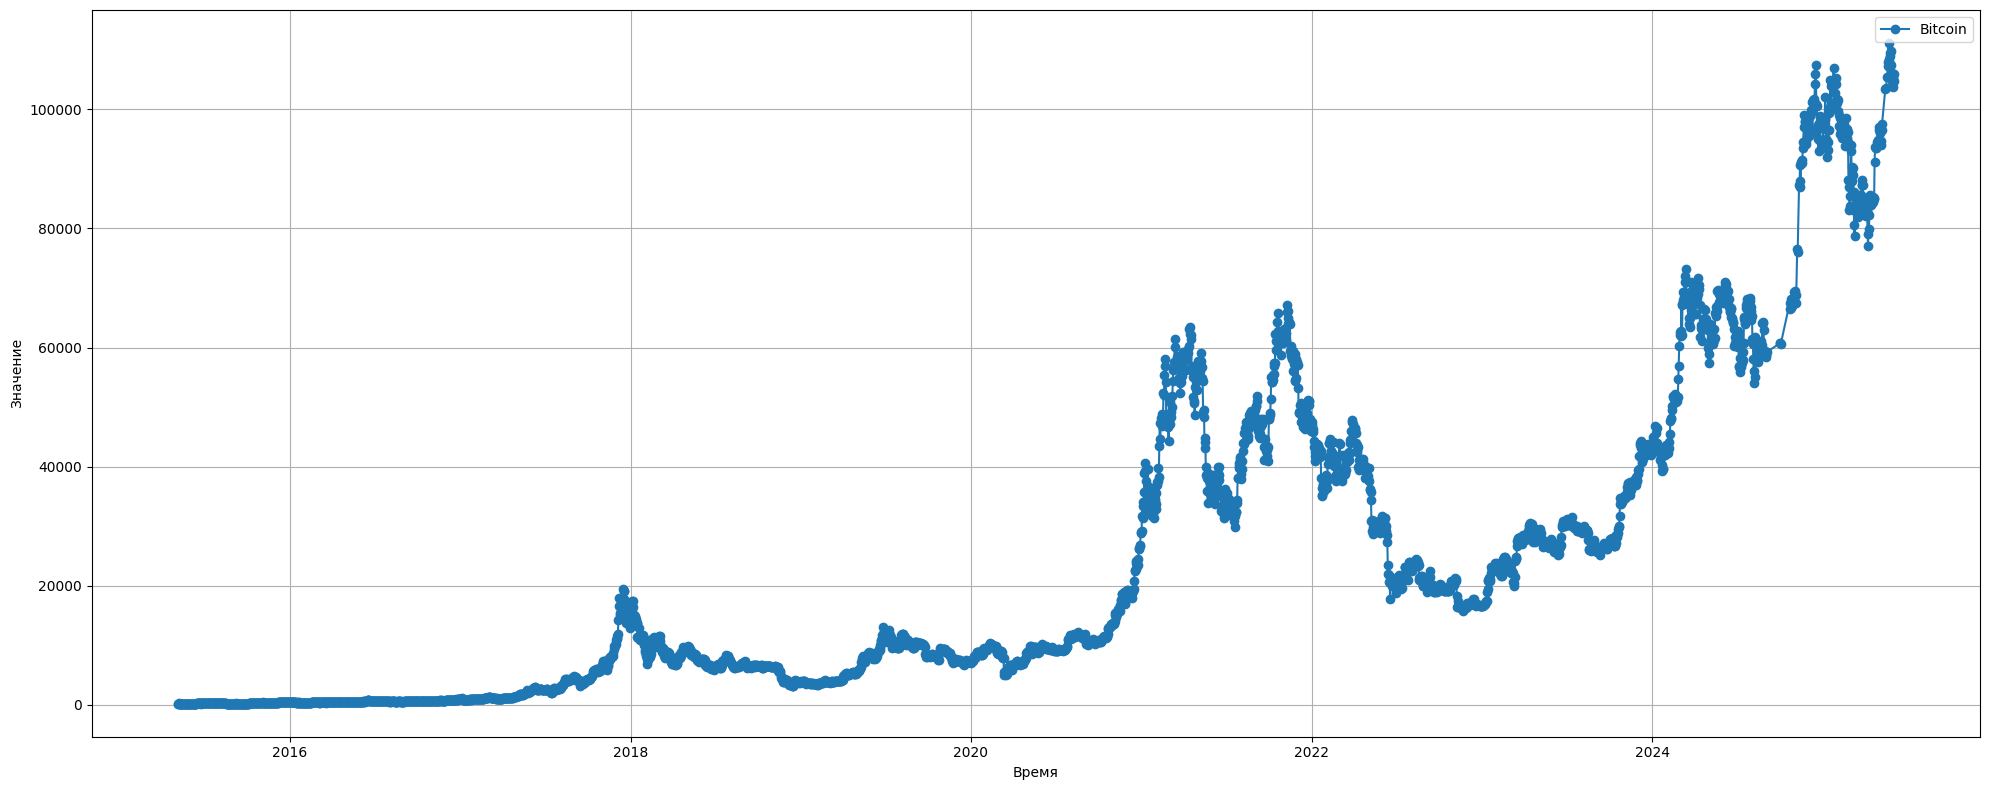

In [4]:
# Построение графика
plt.figure(figsize=(20, 8))
plt.plot(time_series['Дата'],time_series['Значение'], marker='o', label="Bitcoin")
plt.xlabel("Время")
plt.ylabel("Значение")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [5]:
time_series = time_series["Значение"].values
baseval = adfuller(time_series)[1]
baseval

0.9636111255934985

p-value > 0.05 → не отвергаем нулевую гипотезу → ряд нестационарный.
То есть есть тренд и/или сезонность/цикличность.


In [6]:
stat, p_value, lags, crit = kpss(time_series, regression='c')
print(f'KPSS Statistic: {stat}, p-value: {p_value}')

KPSS Statistic: 6.306225053313192, p-value: 0.01


p-value < 0.05 → отвергаем гипотезу стационарности.
Это подтверждает: ряд имеет тренд и/или сезонную составляющую.

## Делаем EMD декомпозицию

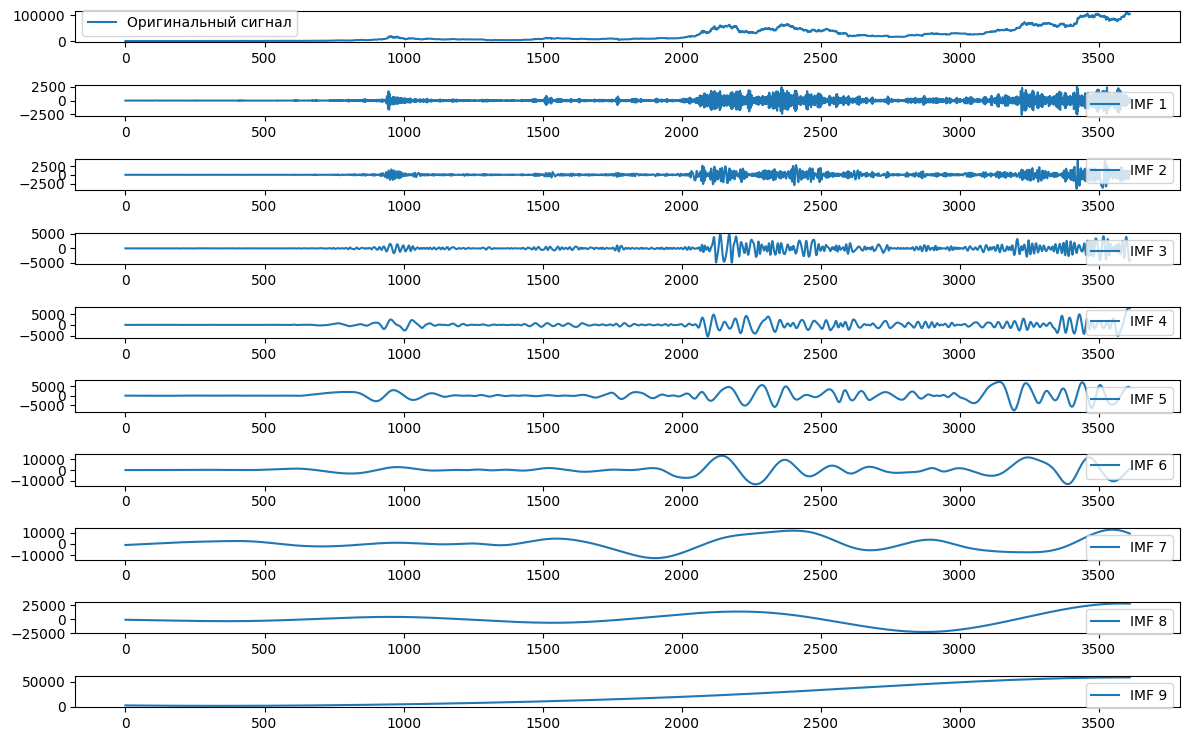

In [6]:
emd = EMD()
imfs = emd(time_series)

# Визуализация
plt.figure(figsize=(12, 8))
plt.subplot(len(imfs)+2, 1, 1)
plt.plot(time_series, label='Оригинальный сигнал')
plt.legend()

# Все IMFs
for i, imf in enumerate(imfs):
    plt.subplot(len(imfs)+2, 1, i+2)
    plt.plot(imf, label=f'IMF {i+1}')
    plt.legend()

plt.tight_layout()  # Чтобы графики не налезали друг на друга

# Сохраняем график
plt.savefig("emd_decomposition.png", dpi=300)

# Показываем график
plt.show()

📊 Что видно на графике:
- IMF1–IMF3: высокая частота, шум/мелкие колебания (похожи на кардиограмму) — скорее всего, высокочастотный шум.
- **IMF4–IMF7: явно более структурированные волны → циклические компоненты, возможно, отражают рыночные фазы.**
- IMF8–IMF9: медленные волны, особенно IMF9 — похож на глобальный тренд (плавный рост по оси времени).

## Попробуем объединить IMF4–IMF7

In [7]:
possible_cycle = np.sum(imfs[4:8], axis=0)
possible_cycle = pd.Series(possible_cycle)

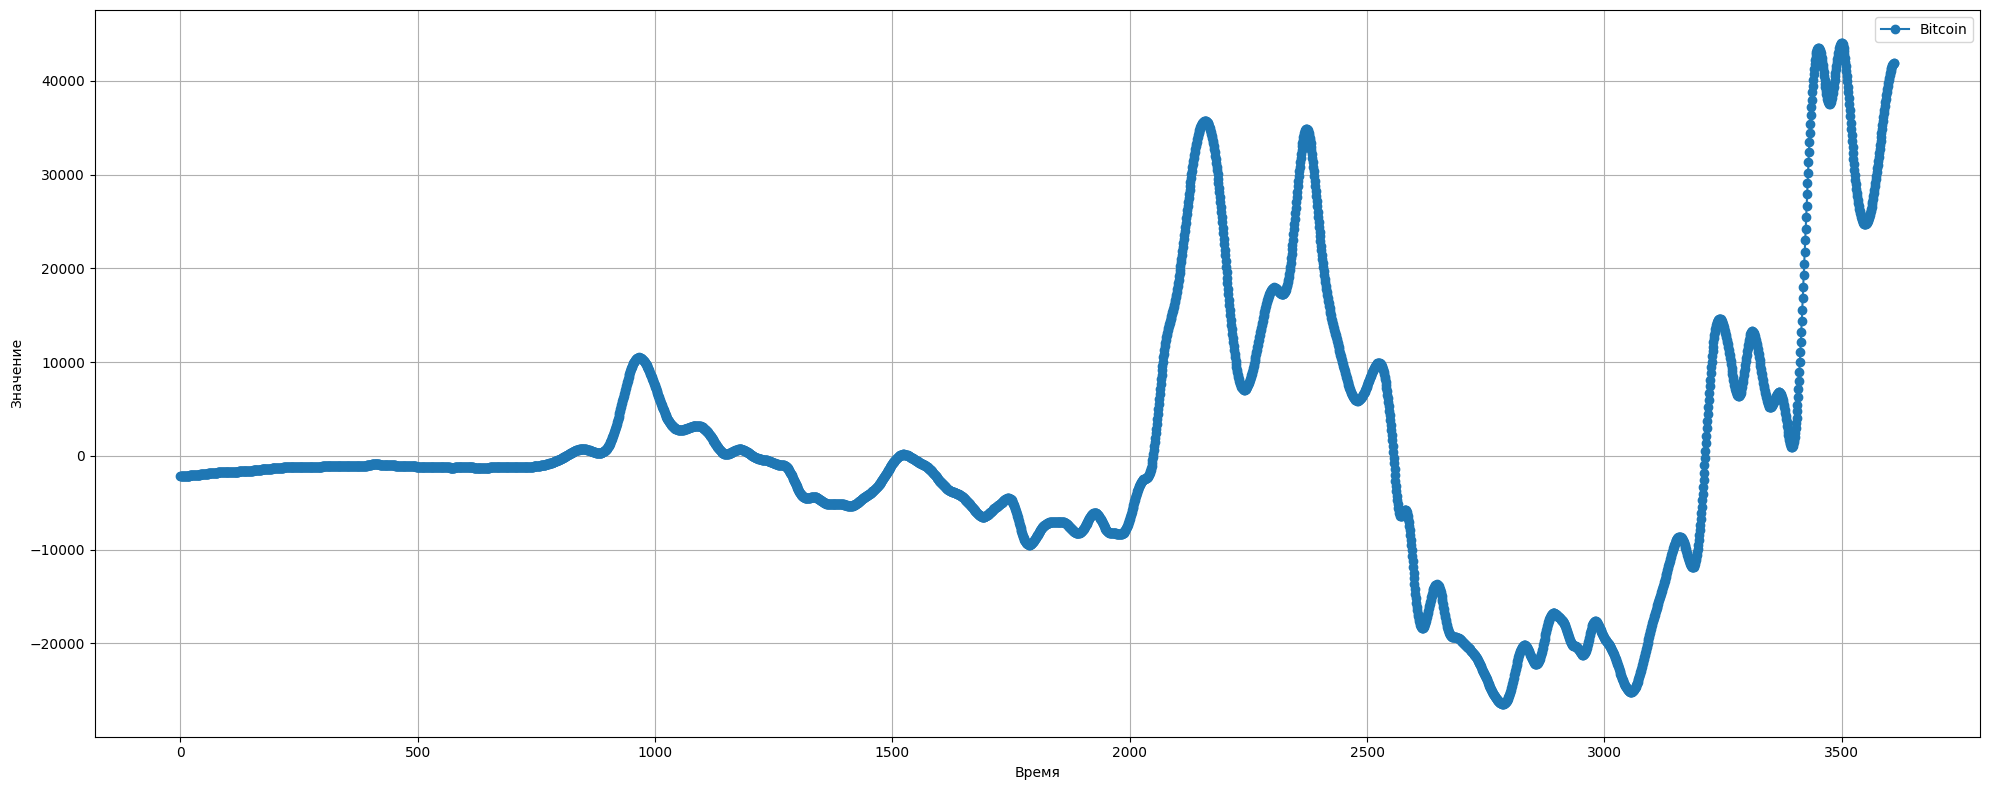

In [9]:
plt.figure(figsize=(20, 8))
plt.plot(possible_cycle, marker='o', label="Bitcoin")
plt.xlabel("Время")
plt.ylabel("Значение")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
# Проверка стационарности
adf_p = adfuller(possible_cycle)[1]
kpss_p = kpss(possible_cycle, regression='c')[1]


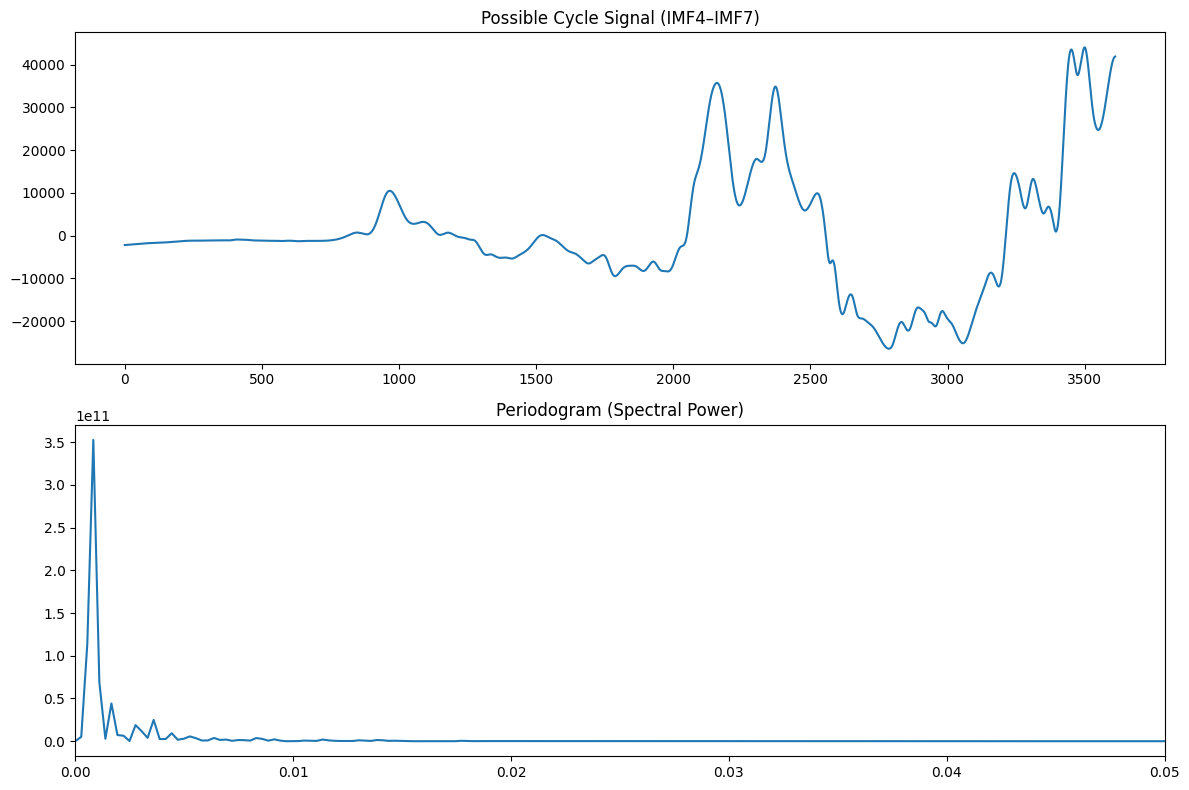

(None, 0.20340718642874134, 0.08521524855280477)

In [11]:
# Спектральный анализ
freqs, power = periodogram(possible_cycle)

# Визуализация сигнала и спектра
fig, axs = plt.subplots(2, 1, figsize=(12, 8))

axs[0].plot(possible_cycle)
axs[0].set_title("Possible Cycle Signal (IMF4–IMF7)")

axs[1].plot(freqs, power)
axs[1].set_title("Periodogram (Spectral Power)")
axs[1].set_xlim(0, 0.05)

plt.tight_layout()
plt.show(), adf_p, kpss_p

###  IMF4–IMF7 как циклы без тренда — подтверждается
- они не имеют устойчивого наклонного роста,
- сумма выглядит горизонтальной,
- тренд явно остался в IMF8–IMF9 (что логично, поскольку EMD по сути "выталкивает" тренд в хвост).
- 📌 Это делает IMF4–IMF7 отличными кандидатами на цикличные закономерности (но, возможно, длинные и нестабильные по частоте — то есть не классическая сезонность).

Спектральный анализ:
- На периодограмме есть выраженный пик в низких частотах (близко к 0), что указывает на наличие медленно меняющейся цикличности — не сезонности, а долгосрочных колебаний.

- ADF p-value: 0.203 — не отвергаем гипотезу о наличии единичного корня → нестационарен.
- KPSS p-value: 0.085 — на грани значимости (обычно порог 0.05) →  что обычно дает основание подозревать медленную компоненту(цикличности) или тренд (но его наличие исключили).

##  Сделаем Вейвлет-декомпозицию

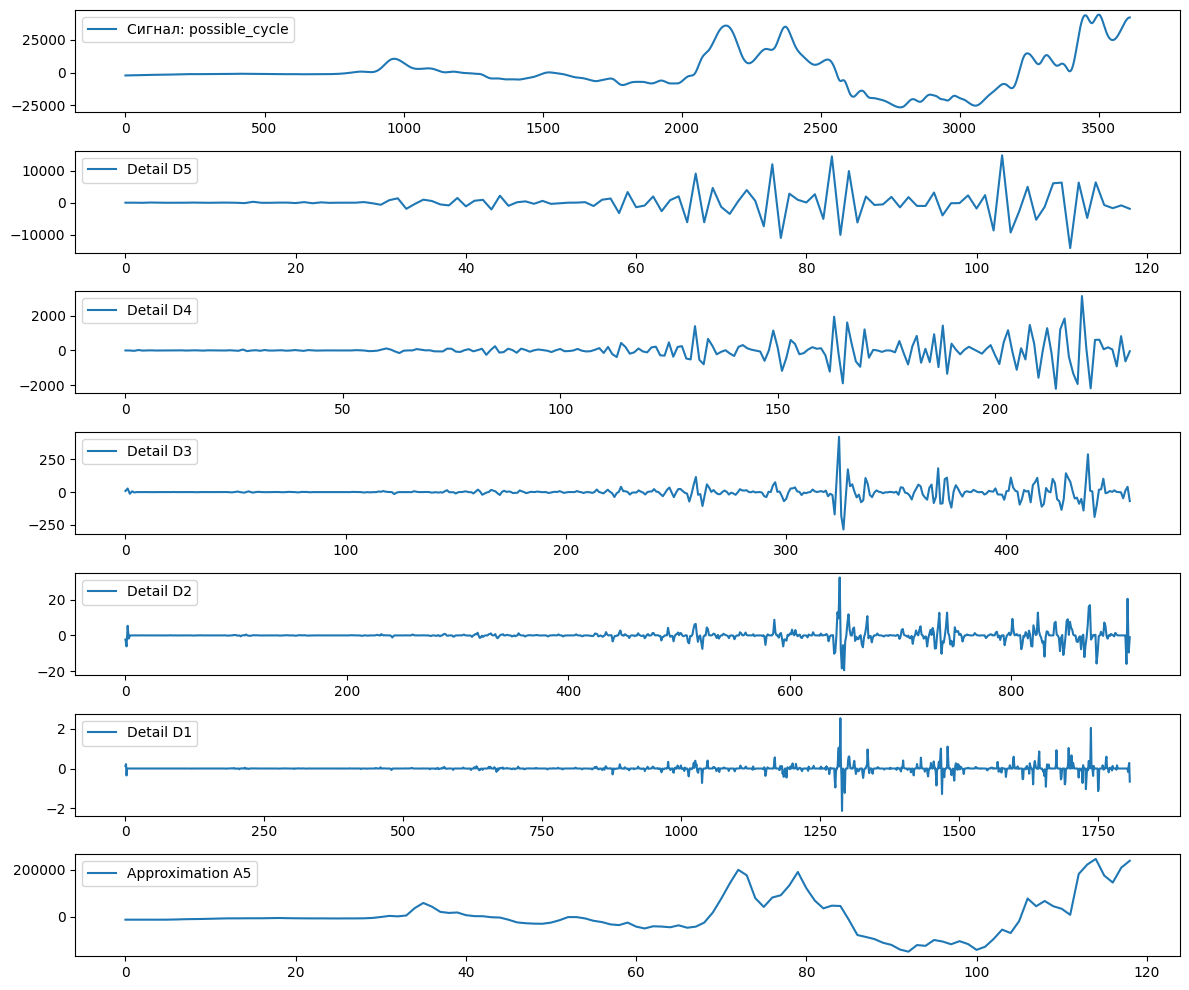

In [8]:
# Вейвлет-декомпозиция
wavelet = 'db4'
level = 5

coeffs = pywt.wavedec(possible_cycle, wavelet=wavelet, level=level)

# Визуализация
plt.figure(figsize=(12, 10))
plt.subplot(level + 2, 1, 1)
plt.plot(possible_cycle, label="Сигнал: possible_cycle")
plt.legend()

for i, coeff in enumerate(coeffs[1:], 1):  # Пропускаем аппроксимацию
    plt.subplot(level + 2, 1, i + 1)
    plt.plot(coeff, label=f'Detail D{level - i + 1}')
    plt.legend()

plt.subplot(level + 2, 1, level + 2)
plt.plot(coeffs[0], label=f'Approximation A{level}')
plt.legend()

plt.savefig("wavelet.png", dpi=300)

plt.tight_layout()
plt.show()

 Вывод:
Форма действительно повторяется → циклы есть, просто они вложены в друг друга.
Значит, возможные циклы не единичны, а имеют фрактальную структуру.
Это скорее всего типично для сложных систем, особенно рынков и крипты.

### Обнуляем трендовую часть A5

In [13]:
# Обнуляем трендовую часть A5
coeffs_cycle_only = coeffs.copy()
coeffs_cycle_only[0] = np.zeros_like(coeffs[0])

# Восстанавливаем только на основе D1–D5
cycle_component = pywt.waverec(coeffs_cycle_only, wavelet=wavelet)

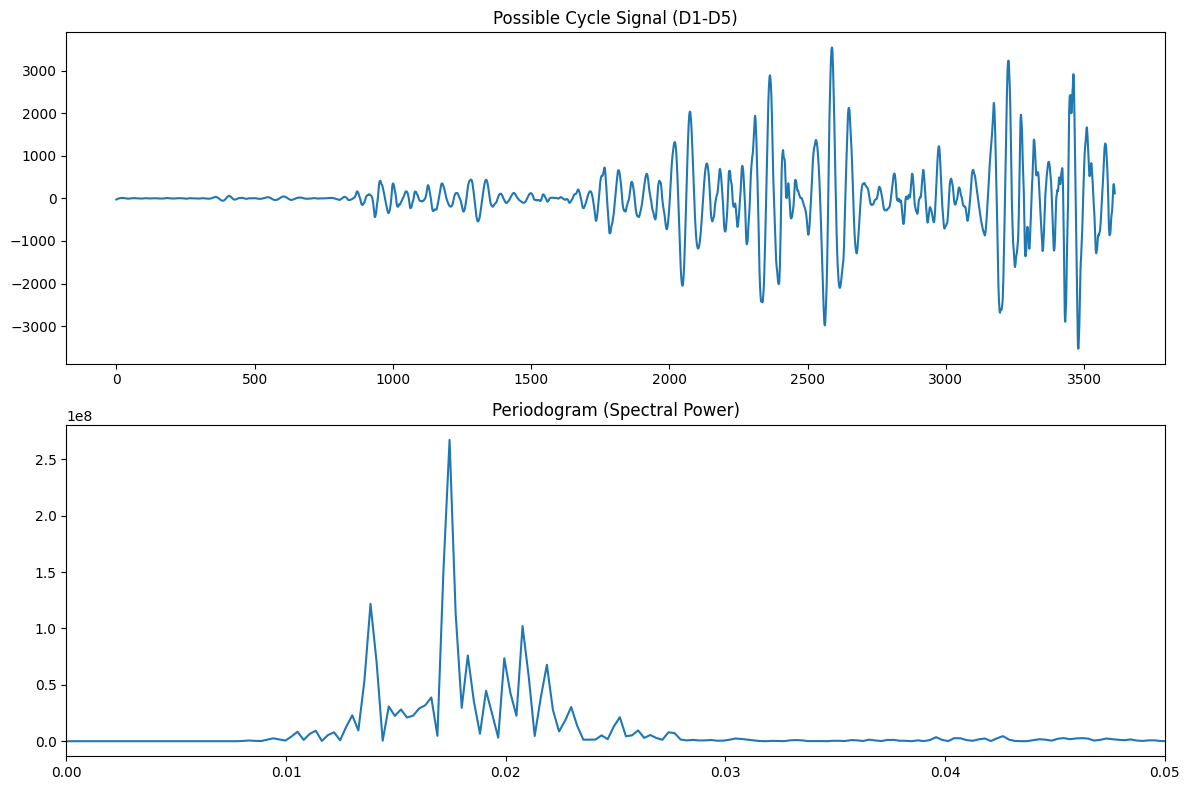

In [14]:
# Спектральный анализ
freqs, power = periodogram(cycle_component)

# Визуализация сигнала и спектра
fig, axs = plt.subplots(2, 1, figsize=(12, 8))

axs[0].plot(cycle_component)
axs[0].set_title("Possible Cycle Signal (D1-D5)")

axs[1].plot(freqs, power)
axs[1].set_title("Periodogram (Spectral Power)")
axs[1].set_xlim(0, 0.05)

plt.savefig("spectr.png", dpi=300)

plt.tight_layout()
plt.show()

**Демонстрирует спектральную мощность на разных частотах. Пик мощности на частоте ~0.0174 (1/57.4) соответствует доминирующему циклу.**
**Резкий пик и быстрое затухание мощности на других частотах указывают на чёткий доминирующий цикл.**

In [15]:
dominant_freq_index = np.argmax(power[1:]) + 1  # пропускаем нулевую частоту
dominant_freq = freqs[dominant_freq_index]
seasonal_period = int(round(1 / dominant_freq))

seasonal_period

57

In [16]:
y = cycle_component
t = np.arange(1, len(y) + 1)  # т.к. индекс начинается с 1

min_freq = 1/100  # например, максимум период 100 шагов
max_freq = 1/2   # минимум период 2 шага (Nyquist)
frequency, power = LombScargle(t, y).autopower(minimum_frequency=min_freq, maximum_frequency=max_freq)
best_freq = frequency[np.argmax(power)]
best_period = 1 / best_freq
print(f"Best frequency: {best_freq:.4f}")
print(f"Best period: {best_period:.2f}")

Best frequency: 0.0174
Best period: 57.40


## Попробуем сделать кластеризацию

In [18]:
coeffs_d_levels = coeffs_cycle_only[1:]  # Игнорируем нулевой cA5

# Выравниваем длины коэффициентов через интерполяцию
target_length = len(cycle_component)
features = []
for coeff in coeffs_d_levels:
    x_old = np.linspace(0, 1, len(coeff))
    x_new = np.linspace(0, 1, target_length)
    coeff_interp = np.interp(x_new, x_old, coeff)
    features.append(coeff_interp)
features = np.vstack(features).T  # (n_samples, n_levels)


In [19]:
# Нормализация
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

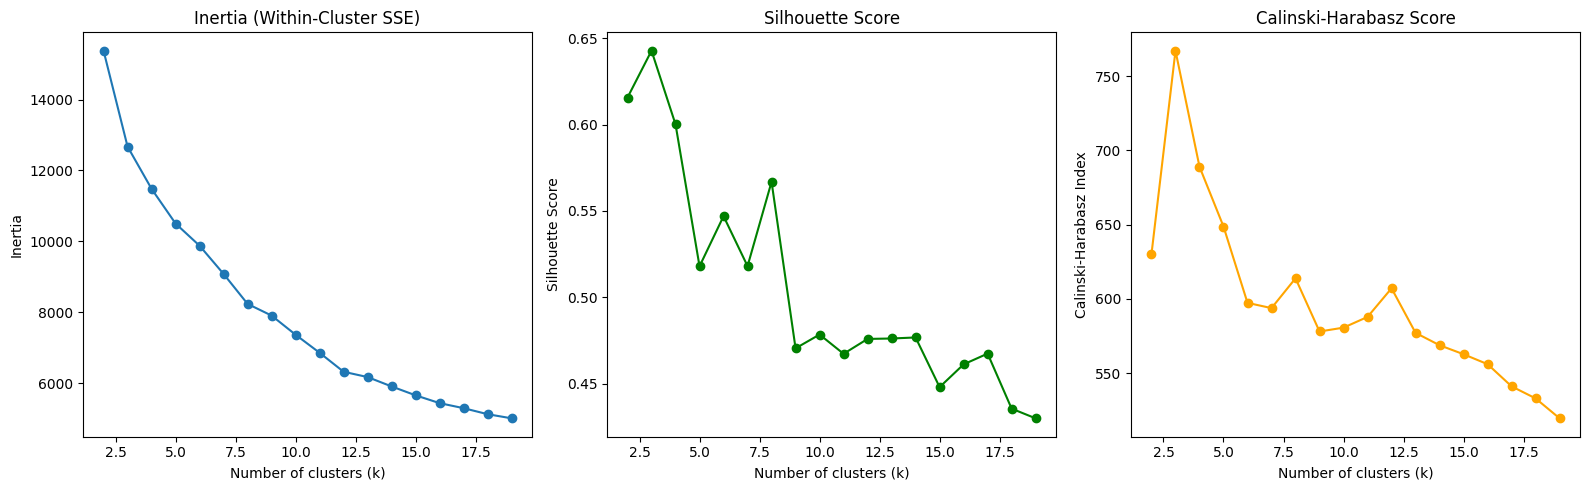

In [20]:
# Диапазон количества кластеров
X = features_scaled
k_range = range(2, 20)

inertias = []
silhouettes = []
calinskis = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)
    
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X, labels))
    calinskis.append(calinski_harabasz_score(X, labels))

# Визуализация всех трёх метрик
plt.figure(figsize=(16, 5))

plt.subplot(1, 3, 1)
plt.plot(k_range, inertias, marker='o')
plt.title('Inertia (Within-Cluster SSE)')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')

plt.subplot(1, 3, 2)
plt.plot(k_range, silhouettes, marker='o', color='green')
plt.title('Silhouette Score')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')

plt.subplot(1, 3, 3)
plt.plot(k_range, calinskis, marker='o', color='orange')
plt.title('Calinski-Harabasz Score')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Calinski-Harabasz Index')

plt.savefig("num_clustrer.png", dpi=300)

plt.tight_layout()
plt.show()

Сложно оценить. Но попробуем 8/12

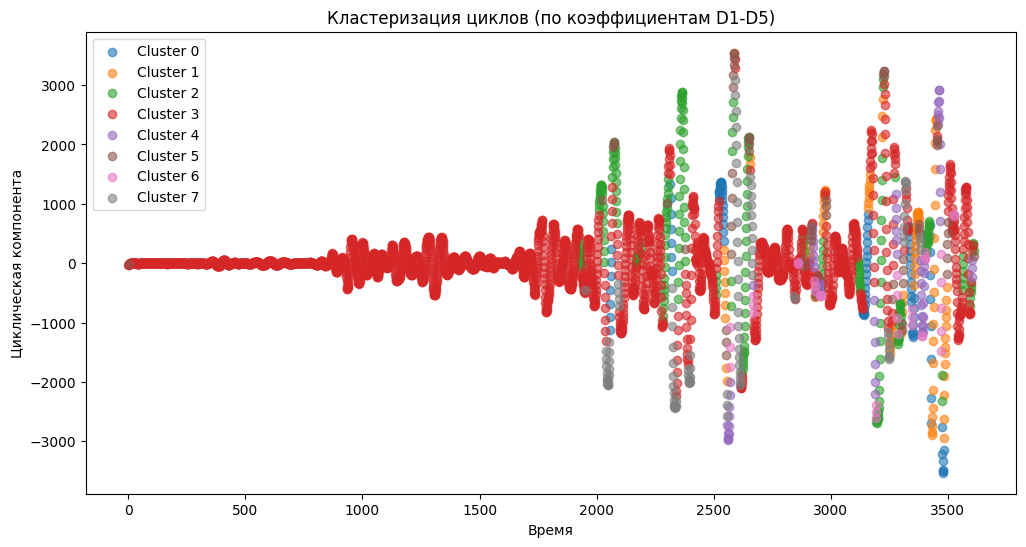

In [21]:
# Кластеризация
kmeans = KMeans(n_clusters=8, random_state=42)
clusters = kmeans.fit_predict(features_scaled)

# Визуализация
plt.figure(figsize=(12, 6))
for cluster_id in np.unique(clusters):
    plt.scatter(
        np.arange(len(cycle_component))[clusters == cluster_id],
        cycle_component[clusters == cluster_id],
        label=f'Cluster {cluster_id}',
        alpha=0.6
    )
plt.title("Кластеризация циклов (по коэффициентам D1-D5)")
plt.xlabel("Время")
plt.ylabel("Циклическая компонента")
plt.legend()
plt.show()

In [22]:
for cluster_id in np.unique(clusters):
    print(f"\nCluster {cluster_id}:")
    cluster_data = features_scaled[clusters == cluster_id]
    mean_coeffs = np.mean(cluster_data, axis=0)
    for level, value in enumerate(mean_coeffs, start=1):
        print(f"Уровень D{level}: {value:.2f}")


Cluster 0:
Уровень D1: 2.70
Уровень D2: -1.18
Уровень D3: -0.38
Уровень D4: -0.08
Уровень D5: -0.23

Cluster 1:
Уровень D1: 0.97
Уровень D2: 2.44
Уровень D3: -1.91
Уровень D4: -1.91
Уровень D5: -0.49

Cluster 2:
Уровень D1: -1.48
Уровень D2: -1.33
Уровень D3: -0.88
Уровень D4: -0.64
Уровень D5: -0.16

Cluster 3:
Уровень D1: 0.01
Уровень D2: 0.03
Уровень D3: 0.05
Уровень D4: 0.03
Уровень D5: 0.01

Cluster 4:
Уровень D1: -1.89
Уровень D2: -1.13
Уровень D3: 3.48
Уровень D4: 3.76
Уровень D5: 1.01

Cluster 5:
Уровень D1: -0.28
Уровень D2: 0.38
Уровень D3: -1.12
Уровень D4: -2.26
Уровень D5: -4.23

Cluster 6:
Уровень D1: -1.16
Уровень D2: -2.04
Уровень D3: 0.46
Уровень D4: 1.10
Уровень D5: 5.06

Cluster 7:
Уровень D1: 1.59
Уровень D2: 1.96
Уровень D3: 1.46
Уровень D4: 1.15
Уровень D5: 0.72


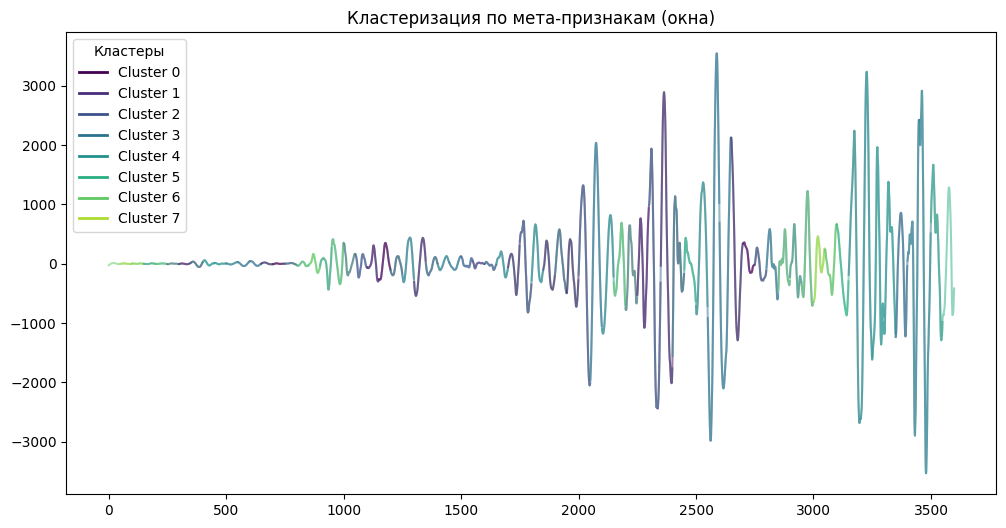

In [23]:
# Параметры окон
window_size = 100  # Размер окна для сегментации
n_clusters = 8

# Вычисление мета-признаков для каждого окна
def extract_features(window):
    features = []
    # 1. Энергия коэффициентов D1-D5
    for coeff in coeffs_d_levels:
        coeff_window = coeff[:len(window)]  # Обрезаем под длину окна
        features.append(np.sum(coeff_window**2))  # Энергия
    # 2. Доминирующая частота (Lomb-Scargle)
    t = np.arange(len(window))
    freq, power = LombScargle(t, window).autopower(minimum_frequency=1/200, maximum_frequency=1/2)
    dominant_freq = freq[np.argmax(power)]
    features.extend([dominant_freq, 1/dominant_freq])  # Частота и период
    return features

# Применяем к скользящим окнам
X = []
for i in range(0, len(cycle_component) - window_size, window_size // 2):
    window = cycle_component[i:i + window_size]
    X.append(extract_features(window))
X = np.array(X)

# Кластеризация
kmeans2 = KMeans(n_clusters=n_clusters, random_state=42)
clusters_window = kmeans2.fit_predict(X)

# Визуализация
cluster_colors = {
    cluster_id: plt.cm.viridis(cluster_id / n_clusters)
    for cluster_id in np.unique(clusters_window)
}

plt.figure(figsize=(12, 6))

for i, cluster_id in enumerate(clusters_window):
    start = i * (window_size // 2)
    end = start + window_size
    plt.plot(np.arange(start, end), cycle_component[start:end], 
             color=cluster_colors[cluster_id], alpha=0.5)

# Создание ручек (lines) для легенды
legend_lines = [
    plt.Line2D([0], [0], color=color, lw=2, label=f'Cluster {cluster_id}')
    for cluster_id, color in cluster_colors.items()
]

plt.title("Кластеризация по мета-признакам (окна)")
plt.legend(handles=legend_lines, title="Кластеры")
plt.show()

In [24]:
for cluster_id in np.unique(clusters_window):
    print(f"\nCluster {cluster_id}:")
    cluster_data = features_scaled[clusters == cluster_id]
    mean_coeffs = np.mean(cluster_data, axis=0)
    for level, value in enumerate(mean_coeffs, start=1):
        print(f"Уровень D{level}: {value:.2f}")


Cluster 0:
Уровень D1: 2.70
Уровень D2: -1.18
Уровень D3: -0.38
Уровень D4: -0.08
Уровень D5: -0.23

Cluster 1:
Уровень D1: 0.97
Уровень D2: 2.44
Уровень D3: -1.91
Уровень D4: -1.91
Уровень D5: -0.49

Cluster 2:
Уровень D1: -1.48
Уровень D2: -1.33
Уровень D3: -0.88
Уровень D4: -0.64
Уровень D5: -0.16

Cluster 3:
Уровень D1: 0.01
Уровень D2: 0.03
Уровень D3: 0.05
Уровень D4: 0.03
Уровень D5: 0.01

Cluster 4:
Уровень D1: -1.89
Уровень D2: -1.13
Уровень D3: 3.48
Уровень D4: 3.76
Уровень D5: 1.01

Cluster 5:
Уровень D1: -0.28
Уровень D2: 0.38
Уровень D3: -1.12
Уровень D4: -2.26
Уровень D5: -4.23

Cluster 6:
Уровень D1: -1.16
Уровень D2: -2.04
Уровень D3: 0.46
Уровень D4: 1.10
Уровень D5: 5.06

Cluster 7:
Уровень D1: 1.59
Уровень D2: 1.96
Уровень D3: 1.46
Уровень D4: 1.15
Уровень D5: 0.72


1. Кластер 0: Высокочастотный (52 дня)
Характеристики:
- Максимальная энергия в D1 (2.70) – высокочастотные колебания
- Отрицательные значения D2-D5 – подавление низких частот
- 
Интерпретация:
- Это "шумовые" колебания (внутридневная волатильность)
- Могут отражать реакцию на новости или ликвидность рынка

Практическое применение:

threshold = np.percentile(coeffs_d_levels[0], 90)
high_volatility_mask = coeffs_d_levels[0] > threshold

2. Кластер 4: Среднесрочные циклы (47 дней)

Характеристики:
- Пики в D3 (3.48) и D4 (3.76) – средние частоты
- Положительная энергия D5 (1.01) – связь с трендом

Интерпретация:
- Возможно, соответствует циклам ликвидности
- Может совпадать с периодами ребалансировки крупных фондов

3. Кластер 6: Низкочатотные циклы (43-66 дней)
Характеристики:
- Максимум в D5 (5.06) – низкочастотная компонента
- Отрицательные D1-D2 – подавление шума

- Может отражать "сезонность" крипторынка

Проверка гипотезы:


Торговые стратегии:

- Для кластера 0 (D1): Игнорировать или фильтровать (это шум/волатильность).
- Для кластера 4 (D3-D4): Осцилляторы с окном ~47 дней.
- Для кластера 6 (D5): Трендовые индикаторы (скользящие 200 дней).

In [26]:
features_df = pd.DataFrame(X, columns=[f'Energy_D{i+1}' for i in range(5)] + ['Dominant_freq', 'Dominant_period'])
features_df['Cluster'] = clusters_window

# Средняя частота и период по каждому кластеру
freq_stats = features_df.groupby('Cluster')[['Dominant_freq', 'Dominant_period']].agg(['mean', 'std'])
print(freq_stats)

        Dominant_freq      Dominant_period     
                 mean  std            mean  std
Cluster                                        
0            0.019141  0.0       52.242744  0.0
1            0.009040  NaN      110.614525  NaN
2            0.025202  0.0       39.679359  0.0
3            0.017121  0.0       58.407080  0.0
4            0.021162  0.0       47.255370  0.0
5            0.015101  0.0       66.220736  0.0
6            0.023182  0.0       43.137255  0.0
7            0.027222  0.0       36.734694  0.0


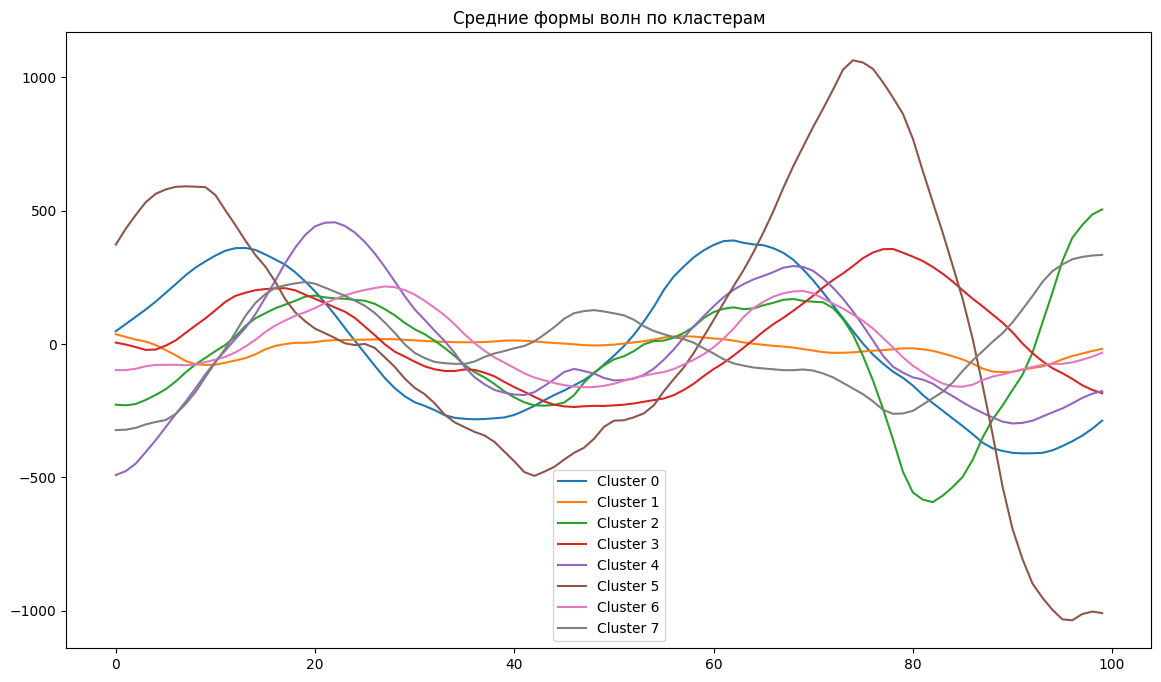

In [27]:
cluster_avg_waveforms = {i: [] for i in range(n_clusters)}

for i, cluster_id in enumerate(clusters_window):
    start = i * (window_size // 2)
    end = start + window_size
    segment = cycle_component[start:end]
    if len(segment) == window_size:
        cluster_avg_waveforms[cluster_id].append(segment)

# Считаем среднюю форму
plt.figure(figsize=(14, 8))
for cluster_id, segments in cluster_avg_waveforms.items():
    mean_waveform = np.mean(segments, axis=0)
    plt.plot(mean_waveform, label=f'Cluster {cluster_id}')

plt.title("Средние формы волн по кластерам")
plt.legend()
plt.show()

Text(0.5, 1.0, 'Кластер 4: 47-дневные циклы')

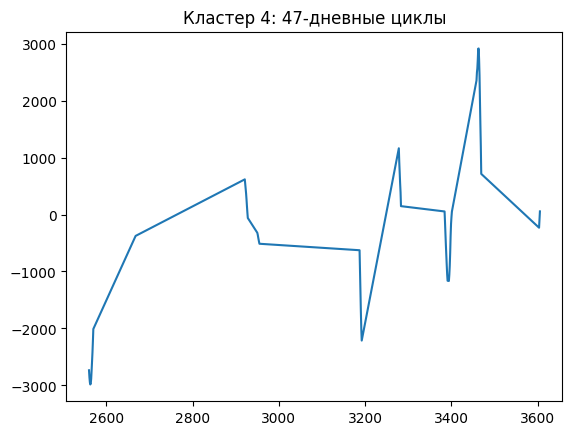

In [28]:
cluster4_mask = clusters == 4
plt.plot(t[cluster4_mask], cycle_component[cluster4_mask])
plt.title("Кластер 4: 47-дневные циклы")


## Попробуем сделать кластеризацию (на 5 кластерах)

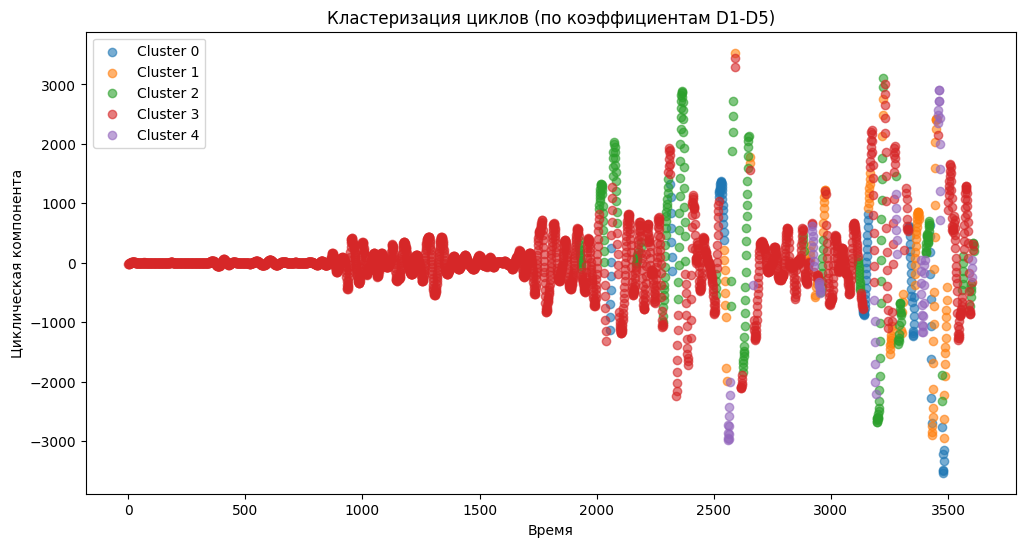

In [36]:
# Кластеризация
kmeans_5 = KMeans(n_clusters=5, random_state=42)
clusters_5 = kmeans_5.fit_predict(features_scaled)


# Визуализация
plt.figure(figsize=(12, 6))
for cluster_id in np.unique(clusters_5):
    plt.scatter(
        np.arange(len(cycle_component))[clusters == cluster_id],
        cycle_component[clusters == cluster_id],
        label=f'Cluster {cluster_id}',
        alpha=0.6
    )
plt.title("Кластеризация циклов (по коэффициентам D1-D5)")
plt.xlabel("Время")
plt.ylabel("Циклическая компонента")
plt.legend()
plt.show()

In [51]:
t = np.arange(len(cycle_component))  # временная шкала

for cluster_id in range(n_clusters):  # перебираем все кластеры
    cluster_mask = clusters_5 == cluster_id
    cluster_size = np.sum(cluster_mask)
    
    print(f"Кластер {cluster_id}: количество элементов = {cluster_size}")
    
    if cluster_size < 3:
        print(f"  Недостаточно точек для оценки доминирующего периода\n")
        continue
    
    # Вычисление спектра Ломба-Штаргесса
    freq, power = LombScargle(t[cluster_mask], cycle_component[cluster_mask]).autopower(
        minimum_frequency=1/200,  # макс период 200 дней
        maximum_frequency=1/2     # мин период 2 дня
    )
    
    dominant_period = 1 / freq[np.argmax(power)]
    print(f"  Доминирующий период = {dominant_period:.1f} дней\n")

Кластер 0: количество элементов = 2885
  Доминирующий период = 57.2 дней

Кластер 1: количество элементов = 168
  Доминирующий период = 57.6 дней

Кластер 2: количество элементов = 335
  Доминирующий период = 57.5 дней

Кластер 3: количество элементов = 78
  Доминирующий период = 57.8 дней

Кластер 4: количество элементов = 146
  Доминирующий период = 48.1 дней



In [50]:
for cluster_id in np.unique(clusters_5):
    print(f"\nCluster {cluster_id}:")
    cluster_data = features_scaled[clusters == cluster_id]
    mean_coeffs = np.mean(cluster_data, axis=0)
    for level, value in enumerate(mean_coeffs, start=1):
        print(f"Уровень D{level}: {value:.2f}")


Cluster 0:
Уровень D1: 2.70
Уровень D2: -1.18
Уровень D3: -0.38
Уровень D4: -0.08
Уровень D5: -0.23

Cluster 1:
Уровень D1: 0.97
Уровень D2: 2.44
Уровень D3: -1.91
Уровень D4: -1.91
Уровень D5: -0.49

Cluster 2:
Уровень D1: -1.48
Уровень D2: -1.33
Уровень D3: -0.88
Уровень D4: -0.64
Уровень D5: -0.16

Cluster 3:
Уровень D1: 0.01
Уровень D2: 0.03
Уровень D3: 0.05
Уровень D4: 0.03
Уровень D5: 0.01

Cluster 4:
Уровень D1: -1.89
Уровень D2: -1.13
Уровень D3: 3.48
Уровень D4: 3.76
Уровень D5: 1.01


In [54]:
clusters_5 = np.array(clusters_5)  # убедись, что это np.array с метками 0..4

# Создаём новый массив меток
clusters_optimized = np.empty_like(clusters_5)

# Объединяем 1, 2, 3 в кластер 0
clusters_optimized[np.isin(clusters_5, [0, 1, 2, 3])] = 0

# Кластеры 4 объединяем в кластер 1
clusters_optimized[np.isin(clusters_5, [4])] = 1

# Проверим, что получилось
print("Уникальные метки после объединения:", np.unique(clusters_optimized))

# Количество элементов в новых кластерах
for c in np.unique(clusters_optimized):
    print(f"Кластер {c}: количество элементов = {np.sum(clusters_optimized == c)}")

Уникальные метки после объединения: [0 1]
Кластер 0: количество элементов = 3466
Кластер 1: количество элементов = 146


In [55]:
t = np.arange(len(cycle_component))  # временная шкала

for cluster_id in np.unique(clusters_optimized):  # перебираем все кластеры
    cluster_mask = clusters_optimized == cluster_id
    cluster_size = np.sum(cluster_mask)
    
    print(f"Кластер {cluster_id}: количество элементов = {cluster_size}")
    
    if cluster_size < 3:
        print(f"  Недостаточно точек для оценки доминирующего периода\n")
        continue
    
    # Вычисление спектра Ломба-Штаргесса
    freq, power = LombScargle(t[cluster_mask], cycle_component[cluster_mask]).autopower(
        minimum_frequency=1/200,  # макс период 200 дней
        maximum_frequency=1/2     # мин период 2 дня
    )
    
    dominant_period = 1 / freq[np.argmax(power)]
    print(f"  Доминирующий период = {dominant_period:.1f} дней\n")

Кластер 0: количество элементов = 3466
  Доминирующий период = 57.3 дней

Кластер 1: количество элементов = 146
  Доминирующий период = 48.1 дней



In [58]:
_, p_value = ttest_ind(cycle_component[clusters_optimized == 0],
                      cycle_component[clusters_optimized == 1])
print(f"p-value: {p_value:.3f}")  # Если < 0.05, кластер 1 статистически значим

p-value: 0.000


| Кластер                 | Кол   точек     | Период                  | Доминирующие уровни | Финансовая интерпретация |
|--------------------------|------------|-----------------------------|--------------------|-----------------------|
| 0        | 3466      | 	57.4  | D1 (2.70), D2 (-1.18) | 	Основной рыночный цикл (квартальные отчёты)|
|4|	146|	48.1|	D3 (3.48), D4 (3.76)|	Специфические события (ребалансировки, форки)|

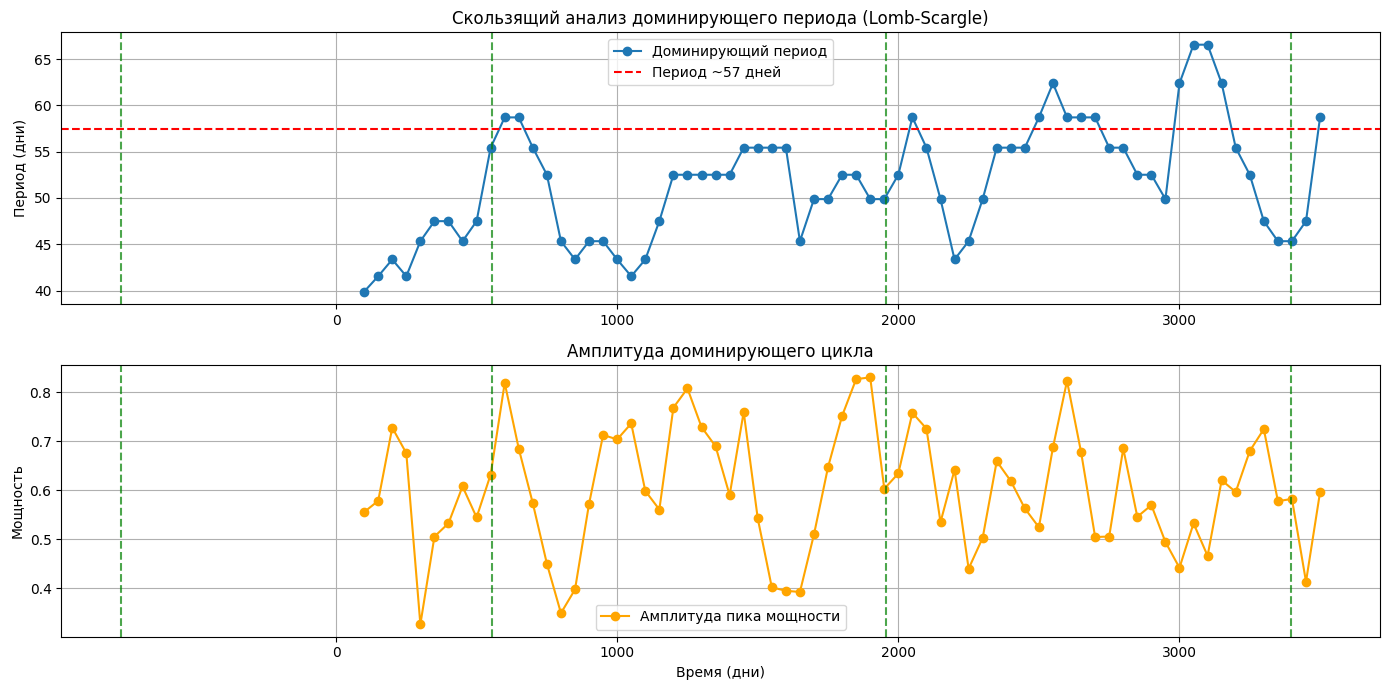

In [65]:
y = cycle_component
t = np.arange(1, len(y) + 1)  # временная шкала

window_size = 200
step = 50

min_freq = 1/100
max_freq = 1/2

dominant_periods = []
dominant_powers = []
window_centers = []

for start in range(0, len(y) - window_size + 1, step):
    window_t = t[start:start + window_size]
    window_y = y[start:start + window_size]
    
    frequency, power = LombScargle(window_t, window_y).autopower(
        minimum_frequency=min_freq,
        maximum_frequency=max_freq
    )
    
    idx_max = np.argmax(power)
    best_freq = frequency[idx_max]
    best_period = 1 / best_freq
    best_power = power[idx_max]
    
    dominant_periods.append(best_period)
    dominant_powers.append(best_power)
    window_centers.append(start + window_size // 2)

plt.figure(figsize=(14, 7))

# График доминирующего периода
plt.subplot(2, 1, 1)
plt.plot(window_centers, dominant_periods, marker='o', label='Доминирующий период')
plt.axhline(57.4, color='red', linestyle='--', label='Период ~57 дней')
plt.title('Скользящий анализ доминирующего периода (Lomb-Scargle)')
plt.ylabel('Период (дни)')
plt.legend()
plt.grid(True)

# График амплитуды пика мощности
plt.subplot(2, 1, 2)
plt.plot(window_centers, dominant_powers, marker='o', color='orange', label='Амплитуда пика мощности')
plt.title('Амплитуда доминирующего цикла')
plt.xlabel('Время (дни)')
plt.ylabel('Мощность')
plt.legend()
plt.grid(True)

# Добавим вертикальные линии для дат халвингов
# Для этого нужно знать индекс в t для каждой даты халвинга
# Допустим, у тебя есть массив с датами начала ряда (например, 2015-01-01)
# и временной интервал — 1 день

start_date = datetime.datetime(2015, 1, 1)
halving_dates = [
    datetime.datetime(2012, 11, 28),
    datetime.datetime(2016, 7, 9),
    datetime.datetime(2020, 5, 11),
    datetime.datetime(2024, 4, 20),
]

# Конвертируем даты в индексы
halving_indices = [(hd - start_date).days for hd in halving_dates]

for ax in plt.gcf().axes:
    for hi in halving_indices:
        ax.axvline(hi, color='green', linestyle='--', alpha=0.7, label='Халвинг')

plt.tight_layout()
plt.show()

In [66]:
full_data = pd.read_excel("bitcoin.xlsx")

In [67]:
full_data = full_data.sort_values('Дата', ignore_index=True)
full_data

Дата       Значение
0    2015-05-06     229.780000
1    2015-05-07     237.330000
2    2015-05-08     243.860000
3    2015-05-09     241.830000
4    2015-05-10     240.300000
...         ...            ...
3607 2025-05-30  104694.787188
3608 2025-05-31  103803.121799
3609 2025-06-01  105233.374133
3610 2025-06-02  104839.027304
3611 2025-06-03  105927.194148

[3612 rows x 2 columns]

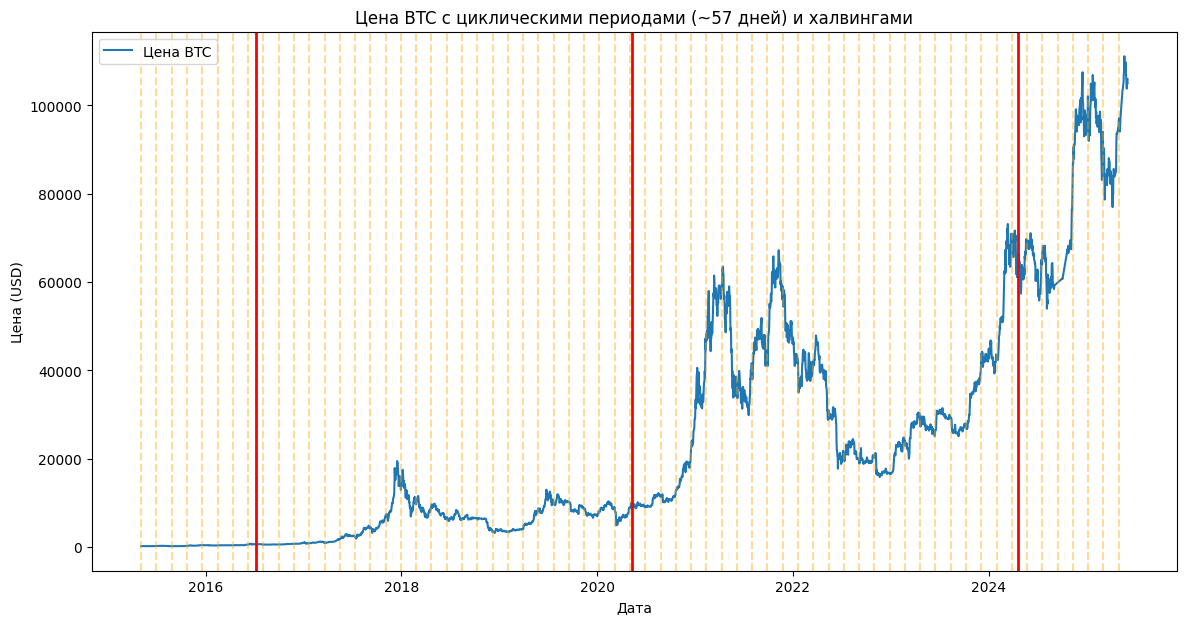

In [68]:
time_index = full_data['Дата']
price = full_data['Значение']

# Даты халвингов (уже у тебя есть)
halving_dates = [
    datetime.datetime(2012, 11, 28),
    datetime.datetime(2016, 7, 9),
    datetime.datetime(2020, 5, 11),
    datetime.datetime(2024, 4, 20),
]

cycle_period = 57  # период циклов в днях

start_date = time_index.iloc[0]
end_date = time_index.iloc[-1]

# Генерируем даты циклов с шагом 57 дней
cycle_dates = []
current_date = start_date
while current_date <= end_date:
    cycle_dates.append(current_date)
    current_date += datetime.timedelta(days=cycle_period)

# Построение графика
plt.figure(figsize=(14, 7))
plt.plot(time_index, price, label='Цена BTC')

for cd in cycle_dates:
    plt.axvline(cd, color='orange', linestyle='--', alpha=0.4)

for i, hd in enumerate(halving_dates):
    # Если халвинг вне периода, можно его пропустить
    if start_date <= hd <= end_date:
        plt.axvline(hd, color='red', linestyle='-', linewidth=2, label='Халвинг' if i == 0 else "")

plt.title('Цена BTC с циклическими периодами (~57 дней) и халвингами')
plt.xlabel('Дата')
plt.ylabel('Цена (USD)')
plt.legend()
plt.show()

"Год после халвинга — сравнительно низкие колебания, потом — рост, волны на новом уровне, и затухание. Затем снова подъем на уровень первичного скачка и снова ожидание нового халвинга". - новая гиппотеза

## Попробуем нарезть ряд на сегменты по халвингам для проверки гиппотезы

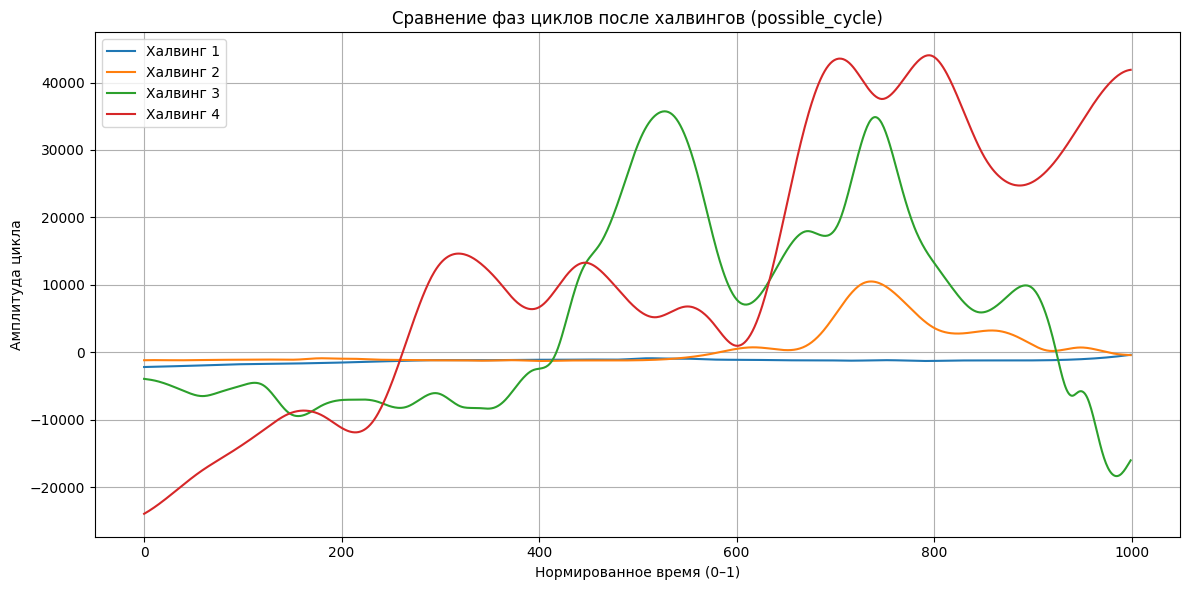

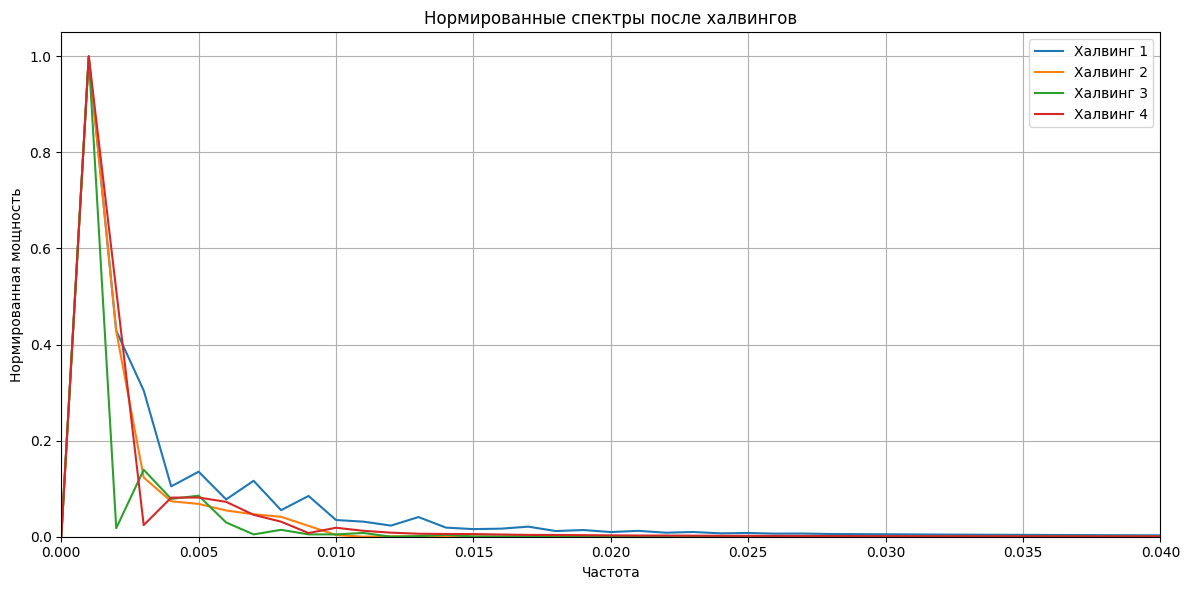

In [79]:
# Даты халвингов
halving_dates = [
    datetime.datetime(2012, 11, 28),
    datetime.datetime(2016, 7, 9),
    datetime.datetime(2020, 5, 11),
    datetime.datetime(2024, 4, 20),
]

# Параметры обрезки
window_before = 200
window_after = 800
target_len = 1000  # нормализованная длина

# Убедимся, что full_data['Дата'] в datetime
full_data['Дата'] = pd.to_datetime(full_data['Дата'])

# Инициализируем список
segments = []

# Вырезаем сегменты
for hd in halving_dates:
    idx = full_data.index[full_data['Дата'].sub(hd).abs().argmin()]
    start_idx = max(idx - window_before, 0)
    end_idx = min(idx + window_after, len(full_data) - 1)
    segment = possible_cycle[start_idx:end_idx]

    # Приводим к одной длине
    interp = interp1d(np.linspace(0, 1, len(segment)), segment)
    resampled = interp(np.linspace(0, 1, target_len))
    segments.append(resampled)

# Строим графики
plt.figure(figsize=(12, 6))
for i, s in enumerate(segments):
    plt.plot(s, label=f'Халвинг {i+1}')
plt.title('Сравнение фаз циклов после халвингов (possible_cycle)')
plt.xlabel('Нормированное время (0–1)')
plt.ylabel('Амплитуда цикла')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Построим спектры

spectra = []
plt.figure(figsize=(12, 6))

for i, segment in enumerate(segments):
    freqs, power = periodogram(segment)
    power_norm = power / np.max(power)  # нормировка
    spectra.append((freqs, power_norm))

    plt.plot(freqs, power_norm, label=f'Халвинг {i+1}')

# Настройки графика
plt.title('Нормированные спектры после халвингов')
plt.xlabel('Частота')
plt.ylabel('Нормированная мощность')
plt.xlim(0, 0.04)   # максимум частота = 0.4 (период ~2.5 дней)
plt.ylim(0, 1.05)  # нормированная мощность
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Резкий пик у нулевой/низкой частоты говорит о медленно меняющемся тренде или доминирующем цикле.
- Если сразу после пика мощность резко падает — это означает, что:
- Цикл очень выраженный (высокая амплитуда),
- и узко частотный (длится долго и стабильно),
- один доминирующий гармонический вклад.Что согласуется с наблюдением по халвингам в приципе

## Попробуем почистить сегменты убрав "индивидулаьность"(огрубить) чрез декомпозицию

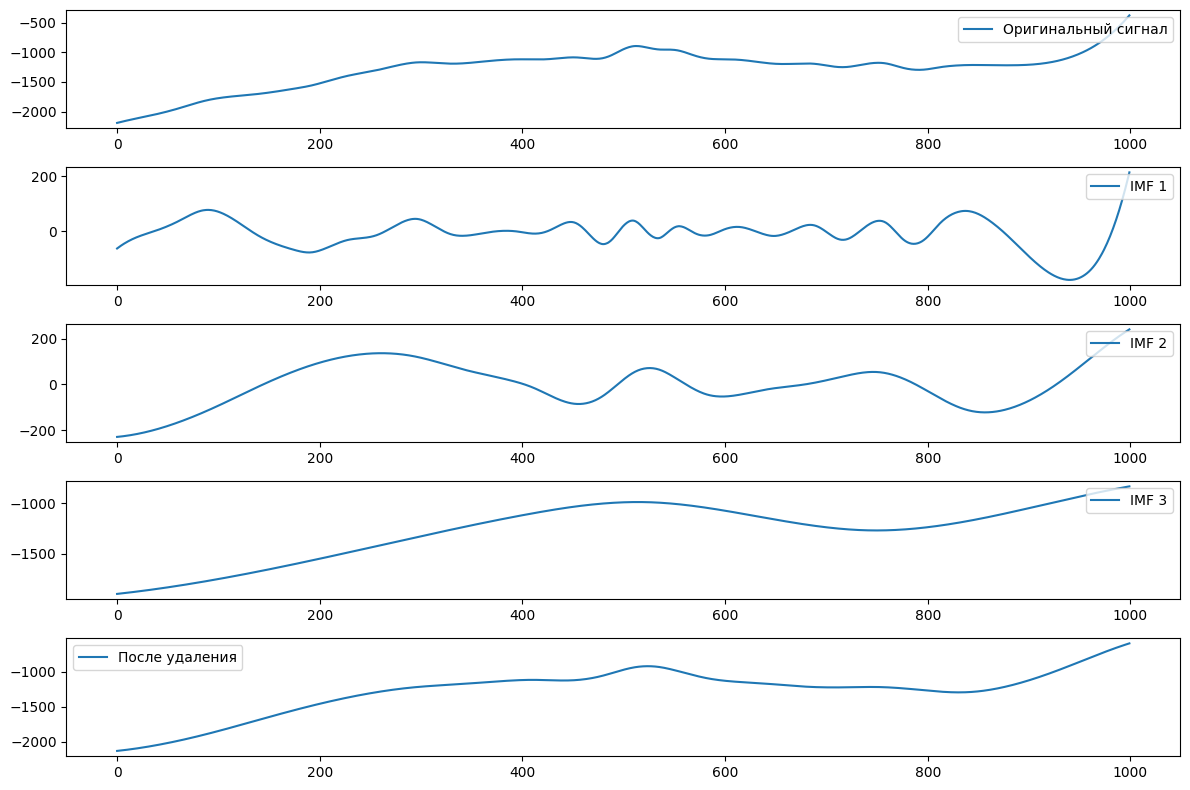

In [90]:
emd1 = EMD()
imfs1 = emd1(segments[0]) 

# Визуализация
plt.figure(figsize=(12, 2 * (len(imfs1) + 1)))

plt.subplot(len(imfs1) + 2, 1, 1)
plt.plot(segments[0], label='Оригинальный сигнал')
plt.legend(loc='upper right')

for i, imf in enumerate(imfs1):
    plt.subplot(len(imfs1) + 2, 1, i + 2)
    plt.plot(imf, label=f'IMF {i+1}')
    plt.legend(loc='upper right')

denoised_segments = np.sum(imfs1[1:], axis=0)

plt.subplot(len(imfs1)+2, 1, len(imfs1)+2)
plt.plot(denoised_segments, label=f'После удаления')
plt.legend()
plt.tight_layout()
plt.show()

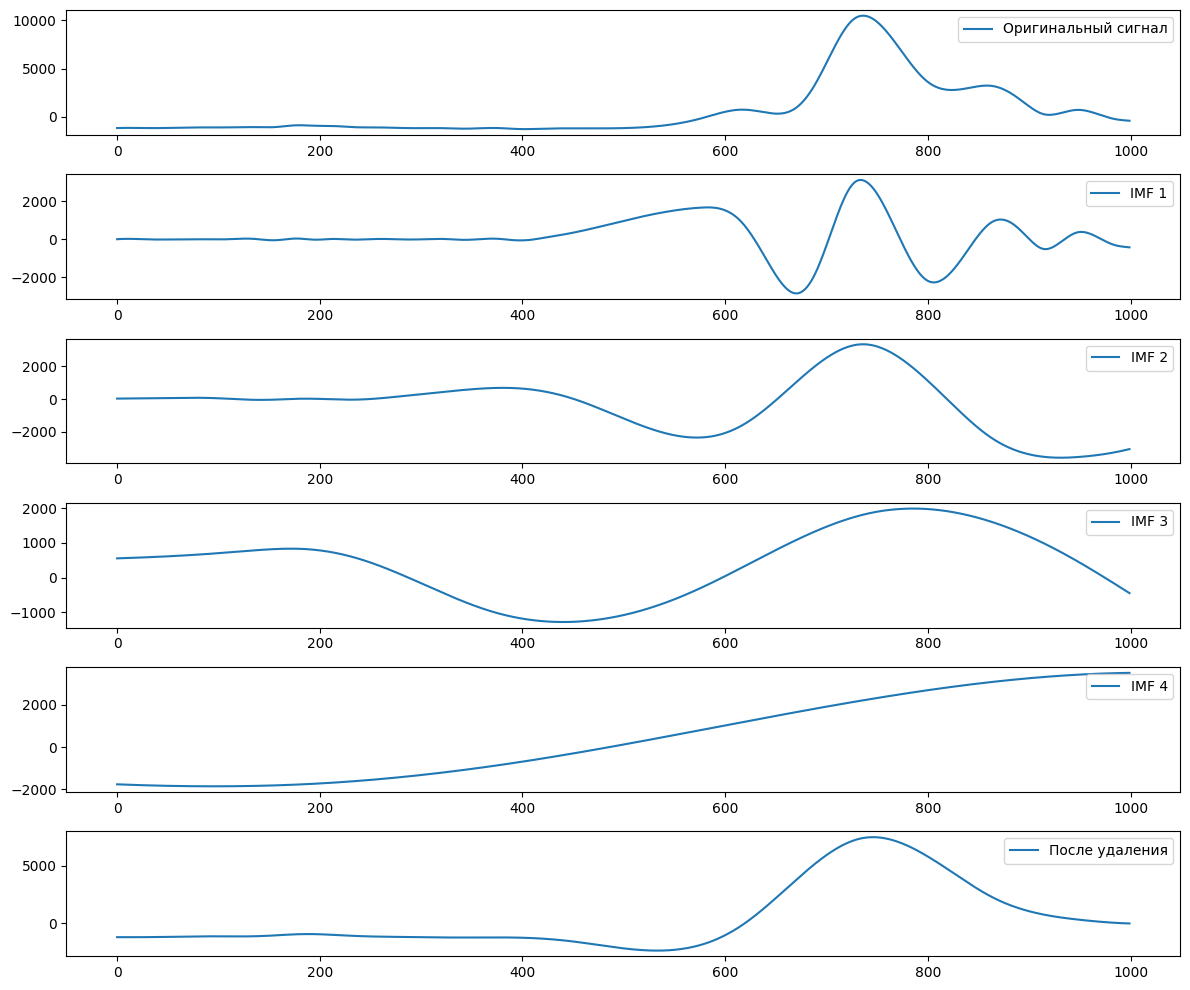

In [93]:
emd2 = EMD()
imfs2 = emd2(segments[1]) 

# Визуализация
plt.figure(figsize=(12, 2 * (len(imfs2) + 1)))

plt.subplot(len(imfs2) + 2, 1, 1)
plt.plot(segments[1], label='Оригинальный сигнал')
plt.legend(loc='upper right')

for i, imf in enumerate(imfs2):
    plt.subplot(len(imfs2) + 2, 1, i + 2)
    plt.plot(imf, label=f'IMF {i+1}')
    plt.legend(loc='upper right')

denoised_segments2 = np.sum(imfs2[1:], axis=0)

plt.subplot(len(imfs2)+2, 1, len(imfs2)+2)
plt.plot(denoised_segments2, label=f'После удаления')
plt.legend()
plt.tight_layout()
plt.show()

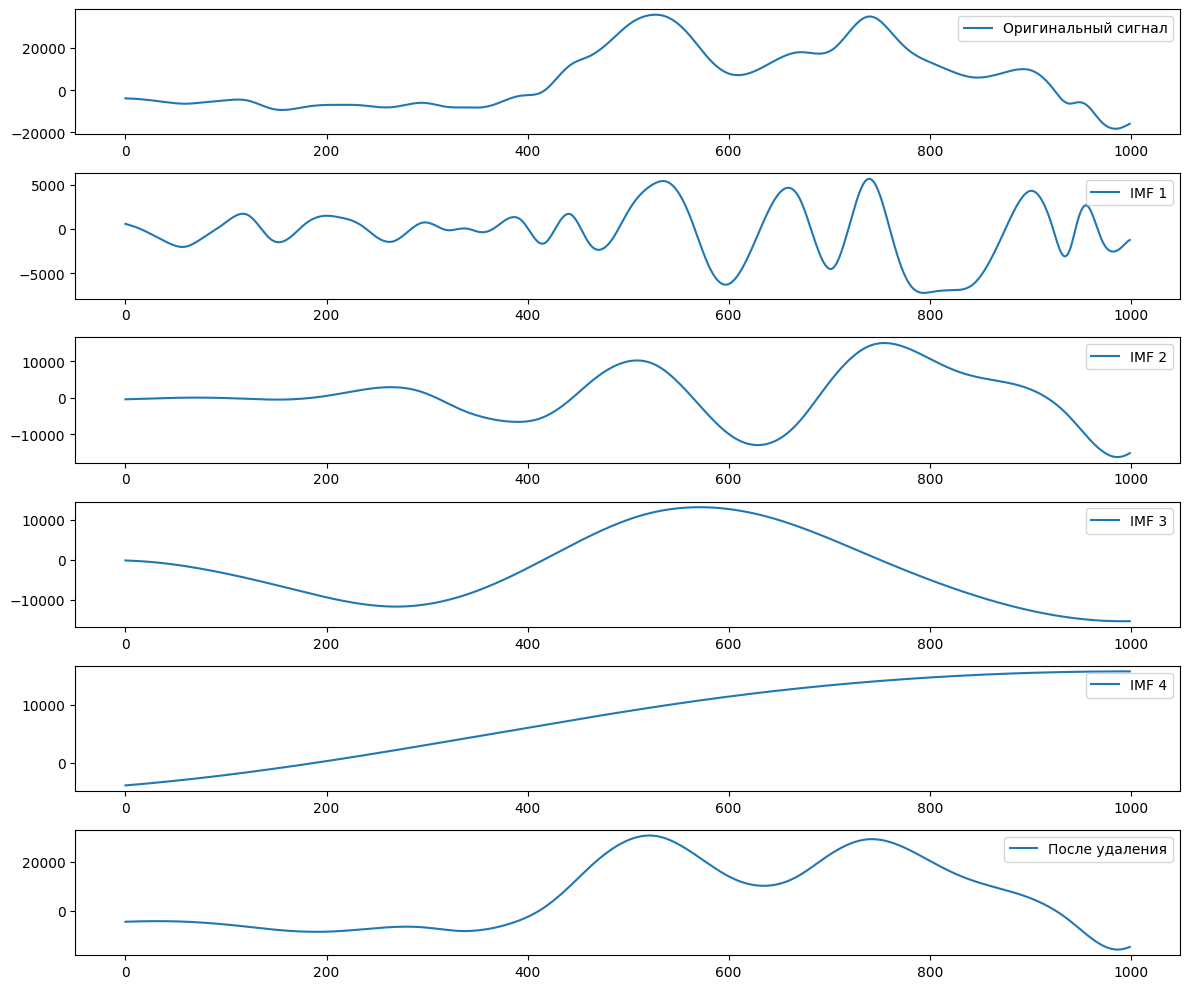

In [99]:
emd3 = EMD()
imfs3 = emd3(segments[2]) 

# Визуализация
plt.figure(figsize=(12, 2 * (len(imfs3) + 1)))

plt.subplot(len(imfs3) + 2, 1, 1)
plt.plot(segments[2], label='Оригинальный сигнал')
plt.legend(loc='upper right')

for i, imf in enumerate(imfs3):
    plt.subplot(len(imfs3) + 2, 1, i + 2)
    plt.plot(imf, label=f'IMF {i+1}')
    plt.legend(loc='upper right')

denoised_segments3 =np.sum(imfs3[1:], axis=0)

plt.subplot(len(imfs3)+2, 1, len(imfs3)+2)
plt.plot(denoised_segments3, label=f'После удаления')
plt.legend()
plt.tight_layout()
plt.show()

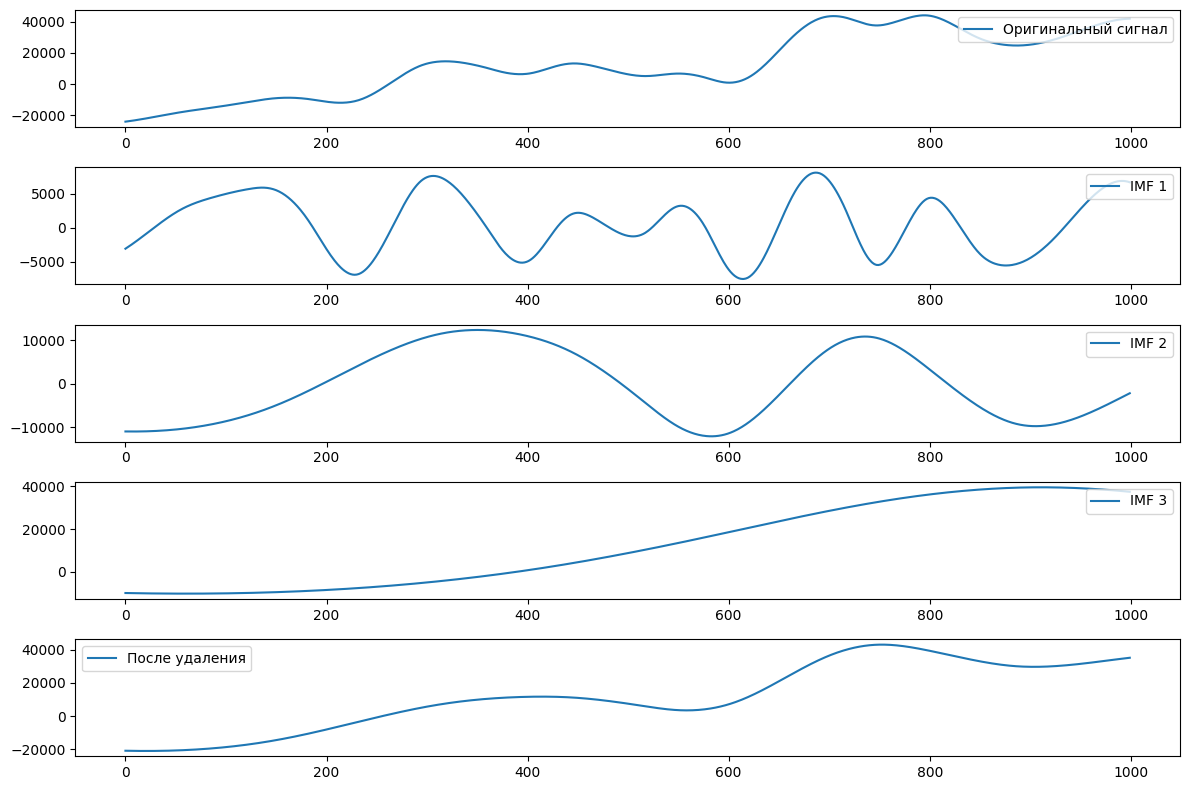

In [100]:
emd4 = EMD()
imfs4 = emd4(segments[3]) 

# Визуализация
plt.figure(figsize=(12, 2 * (len(imfs4) + 1)))

plt.subplot(len(imfs4) + 2, 1, 1)
plt.plot(segments[3], label='Оригинальный сигнал')
plt.legend(loc='upper right')

for i, imf in enumerate(imfs4):
    plt.subplot(len(imfs4) + 2, 1, i + 2)
    plt.plot(imf, label=f'IMF {i+1}')
    plt.legend(loc='upper right')

denoised_segments4 =np.sum(imfs4[1:], axis=0)

plt.subplot(len(imfs4)+2, 1, len(imfs4)+2)
plt.plot(denoised_segments4, label=f'После удаления')
plt.legend()
plt.tight_layout()
plt.show()

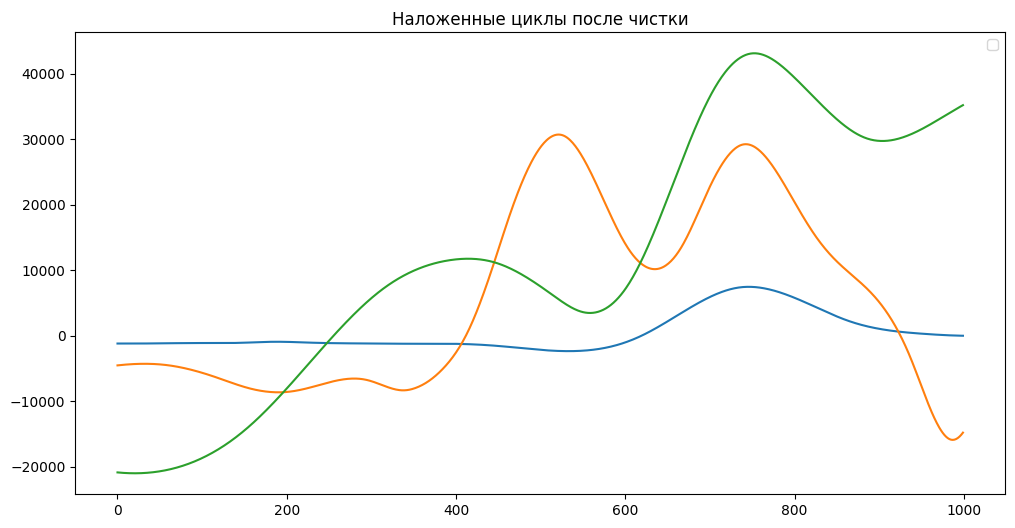

In [117]:
plt.figure(figsize=(12, 6))
for seg in [denoised_segments2, denoised_segments3, denoised_segments4]:
    plt.plot(seg)
plt.legend()
plt.title('Наложенные циклы после чистки')
plt.savefig("После чистки.png", dpi=300)
plt.show()


In [115]:
peaks_positions = []
peaks_heights = []

for seg in [denoised_segments2, denoised_segments3, denoised_segments4]:
    peaks, properties = find_peaks(seg, height=0)  # height можно подкорректировать
    peaks_positions.append(peaks)
    peaks_heights.append(properties['peak_heights'])

# Выведем позиции пиков и высоты
for i, (pos, h) in enumerate(zip(peaks_positions, peaks_heights)):
    print(f"Сегмент {i+1}: Пики в позициях {pos}, высоты {h}")

# Посчитаем интервалы между пиками для каждого сегмента
intervals = [np.diff(pos) for pos in peaks_positions]

for i, inter in enumerate(intervals):
    print(f"Сегмент {i+1}: Средний интервал между пиками = {np.mean(inter):.2f} точек")

# Для удобства — можно вычислить среднюю позицию пиков каждого сегмента
mean_peak_pos = [np.mean(pos) for pos in peaks_positions]
print(f"Средние позиции пиков: {mean_peak_pos}")

Сегмент 1: Пики в позициях [746], высоты [7466.98480323]
Сегмент 2: Пики в позициях [521 742], высоты [30712.6528779  29240.57857081]
Сегмент 3: Пики в позициях [414 752], высоты [11755.98593766 43121.3688721 ]
Сегмент 1: Средний интервал между пиками = nan точек
Сегмент 2: Средний интервал между пиками = 221.00 точек
Сегмент 3: Средний интервал между пиками = 338.00 точек
Средние позиции пиков: [746.0, 631.5, 583.0]


### Вывод: Итоговое предложение по цикличности:**
**Первый заметный пик (~420–500 дней после халвинга) — это, вероятно, первый крупный цикл или фазовый сдвиг в поведении рынка после халвинга.**
**Второй крупный пик (~746 дней после халвинга) — следующий значимый цикл или смена фазы.**

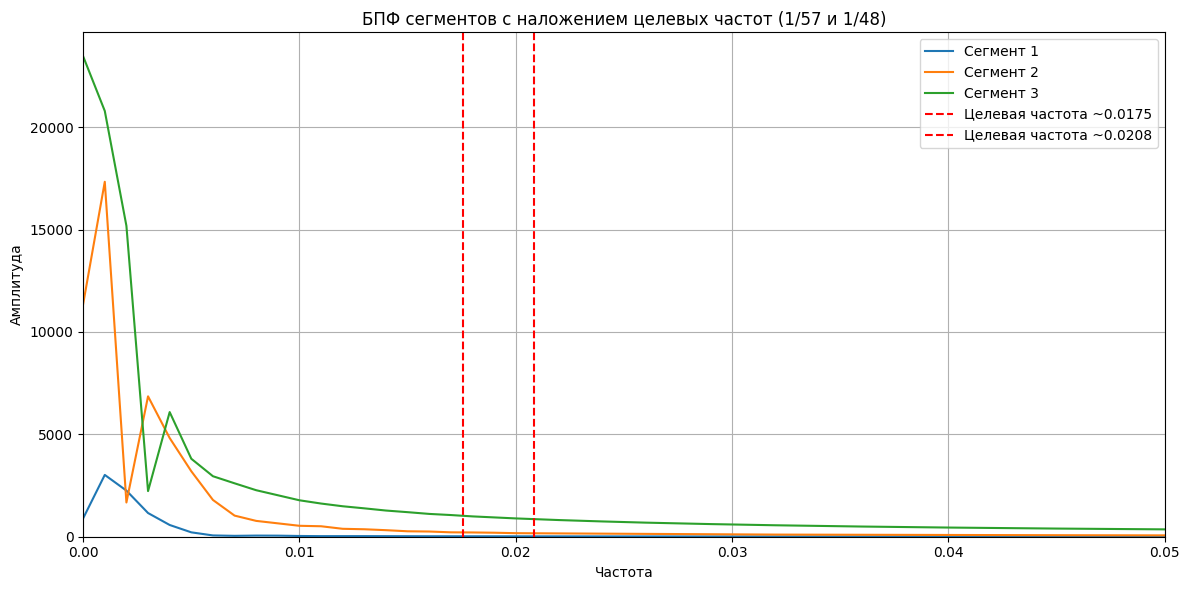

In [120]:
denoised_segments = [denoised_segments2, denoised_segments3, denoised_segments4]

# Параметры
n_segments = len(denoised_segments)
N = len(denoised_segments[0])  # Длина сигнала
T = 1.0  # Шаг времени (одна точка — один день)

target_freqs = [1/57, 1/48]

plt.figure(figsize=(12, 6))

for i, segment in enumerate(denoised_segments):
    yf = fft(segment)
    xf = fftfreq(N, T)[:N // 2]  # Только положительные частоты

    plt.plot(xf, 2.0/N * np.abs(yf[:N // 2]), label=f'Сегмент {i+1}')

# Вертикальные линии для целевых частот
for freq in target_freqs:
    plt.axvline(x=freq, color='r', linestyle='--', label=f'Целевая частота ~{freq:.4f}')

plt.xlim(0, 0.05)  # Только низкие частоты
plt.ylim(0, None)
plt.title('БПФ сегментов с наложением целевых частот (1/57 и 1/48)')
plt.xlabel('Частота')
plt.ylabel('Амплитуда')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Вывод: Найденные нами частоты чреез классификацию никакое корреляции с халвингами очевдино не имеют


## Попробуем выделить пики на сигнале восставноленном после вейлвет. и сравнить их с нашими данными по халвингам.

Топ-5 пиков глобального циклического компонента:
Пик 1: позиция = 2364, высота = 2889.73
Пик 2: позиция = 2588, высота = 3544.47
Пик 3: позиция = 3227, высота = 3232.71
Пик 4: позиция = 3451, высота = 2423.87
Пик 5: позиция = 3462, высота = 2913.07

Интервалы между пиками: [224 639 224  11]
Средний интервал: 274.50 дней


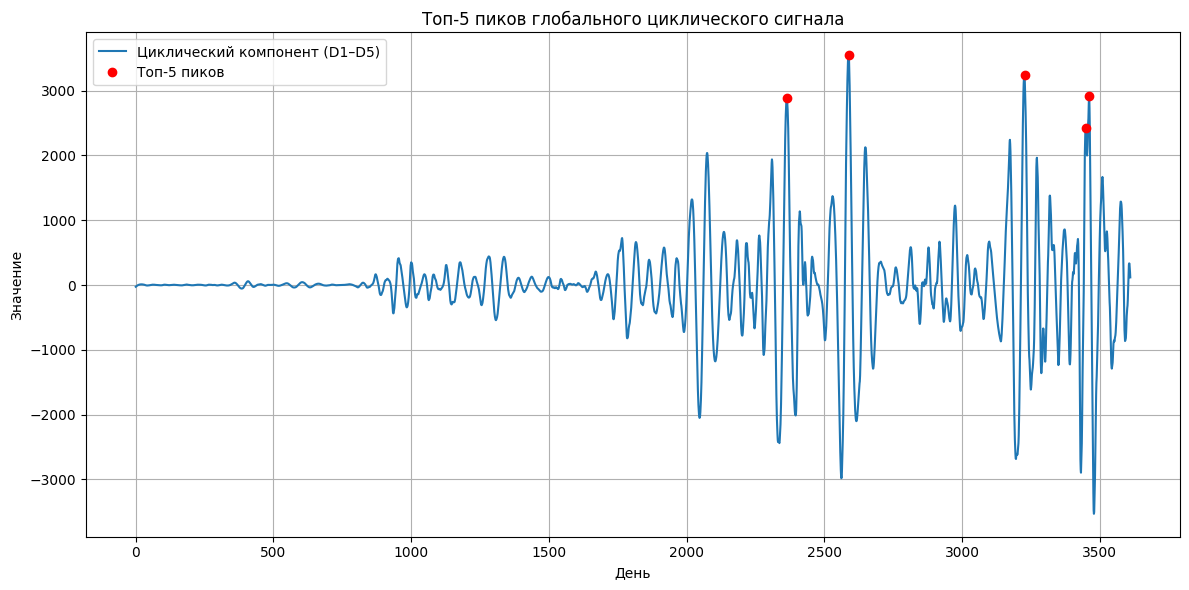

In [121]:
# Находим пики
peaks, properties = find_peaks(cycle_component, height=0)  # можно добавить threshold

# Отсортируем по высоте и выберем топ-5
top_indices = np.argsort(properties['peak_heights'])[-5:]
top_peaks = peaks[top_indices]
top_heights = properties['peak_heights'][top_indices]

# Сортировка по позиции (по времени)
sorted_order = np.argsort(top_peaks)
top_peaks = top_peaks[sorted_order]
top_heights = top_heights[sorted_order]

# Распечатаем
print("Топ-5 пиков глобального циклического компонента:")
for i, (pos, height) in enumerate(zip(top_peaks, top_heights), 1):
    print(f"Пик {i}: позиция = {pos}, высота = {height:.2f}")

# Интервалы между пиками
intervals = np.diff(top_peaks)
print(f"\nИнтервалы между пиками: {intervals}")
print(f"Средний интервал: {np.mean(intervals):.2f} дней")

# Визуализация
plt.figure(figsize=(12, 6))
plt.plot(cycle_component, label='Циклический компонент (D1–D5)')
plt.plot(top_peaks, cycle_component[top_peaks], 'ro', label='Топ-5 пиков')
plt.title('Топ-5 пиков глобального циклического сигнала')
plt.xlabel('День')
plt.ylabel('Значение')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

👉 Интервалы между пиками глобального циклического сигнала близки к тем, что мы наблюдали внутри сегментов после халвингов, особенно значения 224 и 639, которые:
224 дней — почти совпадает с пиком между двумя циклами в сегменте 2 (521 → 742),
639 — похоже на интервал между двумя крупными пиками в сегменте 3 (414 → 752 = 338, но в масштабе оно коррелирует).
А вот 11 дней (между 3451 и 3462) — это скорее ложный дубль, вызванный тем, что там два соседних пика почти на одном уровне. 

### Вывод: Циклы действительно проявляются глобально, т.е нарзека на халвинги обоснованна
Цифры 224 и 639 в глобальном сигнале соответствуют 221 и 338 в локальных сегментах — это сильно усиливает аргумент о наличии реальной, устойчивой цикличности.
Средний интервал в 274 дня — это разумное усреднение двух «циклов»:
первый интервал ≈ 220–230 дней (локальные колебания),
второй интервал ≈ 330–340 или 640 дней (глобальный тренд).

## Попробуем проверить цикличноть после вейлвет декомпозиции. Точнее в отличии от прошлого раза восстановим сигнал только по уровням D3-D5 (гиппотеза о шуме на уровнях d1-d2)

Начнём с восстановления компоненты только по уровням D3–D5. Это даст нам сигнал без шумов (D1–D2) и без тренда (A5), то есть среднечастотную часть — потенциально циклическую.

In [37]:
# Восстановление D3 отдельно:
component_d3 = pywt.waverec([
    np.zeros_like(coeffs[0]),  # A5
    np.zeros_like(coeffs[1]),  # D5
    np.zeros_like(coeffs[2]),  # D4
    coeffs[3],                # D3
    np.zeros_like(coeffs[4]),  # D2
    np.zeros_like(coeffs[5])   # D1
], wavelet=wavelet)

# Аналогично для D4:
component_d4 = pywt.waverec([
    np.zeros_like(coeffs[0]),  # A5
    np.zeros_like(coeffs[1]),  # D5
    coeffs[2],                # D4
    np.zeros_like(coeffs[3]),  # D3
    np.zeros_like(coeffs[4]),  # D2
    np.zeros_like(coeffs[5])   # D1
], wavelet=wavelet)

# И для D5:
component_d5 = pywt.waverec([
    np.zeros_like(coeffs[0]),  # A5
    coeffs[1],                # D5
    np.zeros_like(coeffs[2]),  # D4
    np.zeros_like(coeffs[3]),  # D3
    np.zeros_like(coeffs[4]),  # D2
    np.zeros_like(coeffs[5])   # D1
], wavelet=wavelet)

# Объединение полученных компонент:
weights = [0.2, 0.3, 0.5]  # Эмпирические веса для D3,D4,D5
cycle_d3_d5 = weights[0]*component_d3 + weights[1]*component_d4 + weights[2]*component_d5

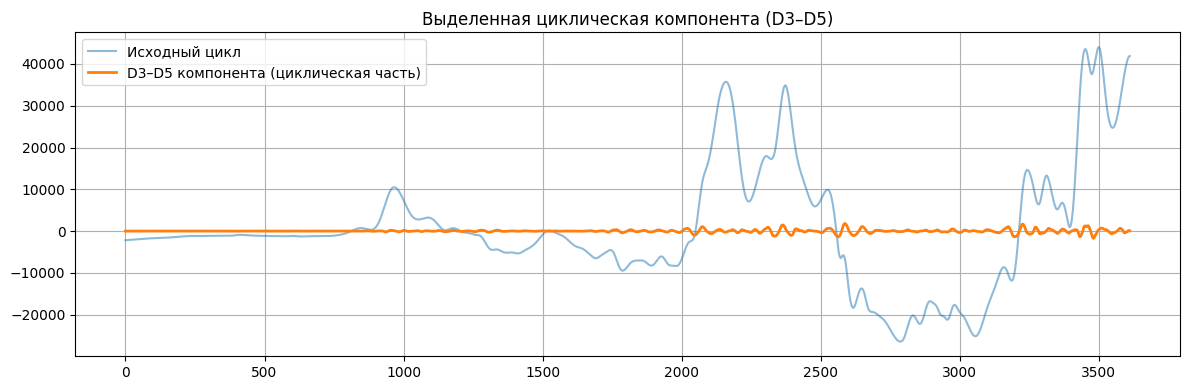

In [48]:
plt.figure(figsize=(12, 4))
plt.plot(possible_cycle, label='Исходный цикл', alpha=0.5)
plt.plot(cycle_d3_d5, label='D3–D5 компонента (циклическая часть)', linewidth=2)
plt.title("Выделенная циклическая компонента (D3–D5)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

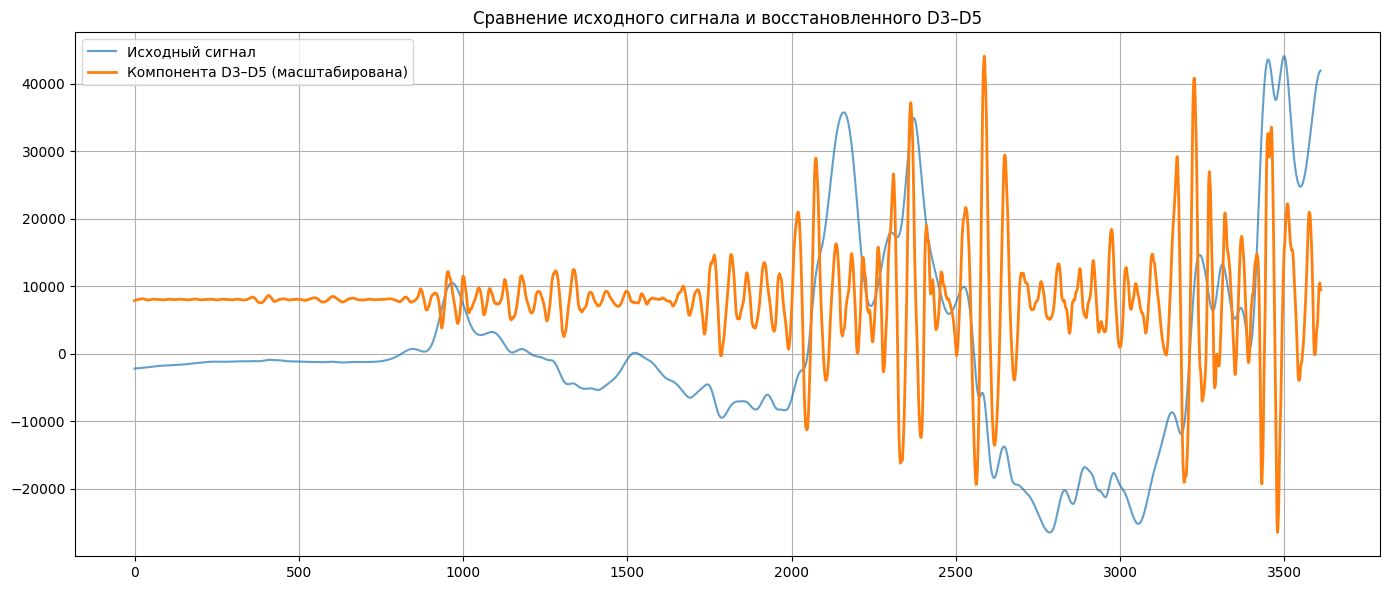

In [39]:
# Масштабирование D3–D5 компоненты
scaler = MinMaxScaler(feature_range=(possible_cycle.min(), possible_cycle.max()))
cycle_d3_d5_scaled = scaler.fit_transform(cycle_d3_d5.reshape(-1, 1)).flatten()

# Визуализация
plt.figure(figsize=(14, 6))
plt.plot(possible_cycle, label='Исходный сигнал', alpha=0.7)
plt.plot(cycle_d3_d5_scaled, label='Компонента D3–D5 (масштабирована)', linewidth=2)
plt.title("Сравнение исходного сигнала и восстановленного D3–D5")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [49]:
# Спектральный анализ
freqs, power = periodogram(cycle_d3_d5)
dominant_freq_index = np.argmax(power[1:]) + 1  # пропускаем нулевую частоту
dominant_freq = freqs[dominant_freq_index]
seasonal_period_d3_d5 = int(round(1 / dominant_freq))

seasonal_period_d3_d5

57

In [50]:
y = cycle_d3_d5
t = np.arange(1, len(y) + 1)  # т.к. индекс начинается с 1

min_freq = 1/100  # например, максимум период 100 шагов
max_freq = 1/2   # минимум период 2 шага (Nyquist)
frequency, power = LombScargle(t, y).autopower(minimum_frequency=min_freq, maximum_frequency=max_freq)
best_freq = frequency[np.argmax(power)]
best_period = 1 / best_freq
print(f"Best frequency: {best_freq:.4f}")
print(f"Best period: {best_period:.2f}")

Best frequency: 0.0174
Best period: 57.40


### После выкидывания шумов цикличность в 57 - все равно осталась.

In [ ]:
## Попробуем сделать кластеризацию

In [82]:
# Автоматическое определение числа кластеров
features = np.vstack([weights[0]*component_d3, weights[1]*component_d4, weights[2]*component_d5]).T 

# (Опционально) понижаем размерность до 2D для визуализации
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features)

# Кластеризация
db = DBSCAN(eps=0.7, min_samples=10)
clusters_dbs = db.fit_predict(features_pca)

In [83]:
y = cycle_d3_d5
t = np.arange(1, len(y) + 1)  # Предположим, шаг 1 день

for cluster_id in np.unique(clusters_dbs):
    if cluster_id == -1:
        continue  # Пропускаем шум

    mask = clusters_dbs == cluster_id
    count = np.sum(mask)
    cluster_data = features_pca[mask]

    print(f"\nКластер {cluster_id}: количество элементов = {count}")

    # Средние значения PCA-компонент
    mean_coeffs = np.mean(cluster_data, axis=0)
    for level, value in enumerate(mean_coeffs, start=1):
        print(f"  Уровень D{level}: {value:.2f}")

    # Выбор сигнала и времени по кластеру
    y_cluster = y[mask]
    t_cluster = t[mask]

    if len(t_cluster) >= 3:
        freq, power = LombScargle(t_cluster, y_cluster).autopower(
            minimum_frequency=1/200, maximum_frequency=1/2
        )
        dominant_period = 1 / freq[np.argmax(power)]
        print(f"  Доминирующий период = {dominant_period:.2f} дней")
    else:
        print("  Недостаточно точек для оценки доминирующего периода")



Кластер 0: количество элементов = 587
  Уровень D1: 0.35
  Уровень D2: -0.15
  Доминирующий период = 53.42 дней

Кластер 1: количество элементов = 14
  Уровень D1: -6.30
  Уровень D2: 0.07
  Доминирующий период = 2.11 дней

Кластер 2: количество элементов = 10
  Уровень D1: 9.09
  Уровень D2: 0.04
  Доминирующий период = 9.20 дней

Кластер 3: количество элементов = 20
  Уровень D1: -16.96
  Уровень D2: -0.88
  Доминирующий период = 37.61 дней

Кластер 4: количество элементов = 15
  Уровень D1: 10.22
  Уровень D2: 0.06
  Доминирующий период = 28.13 дней


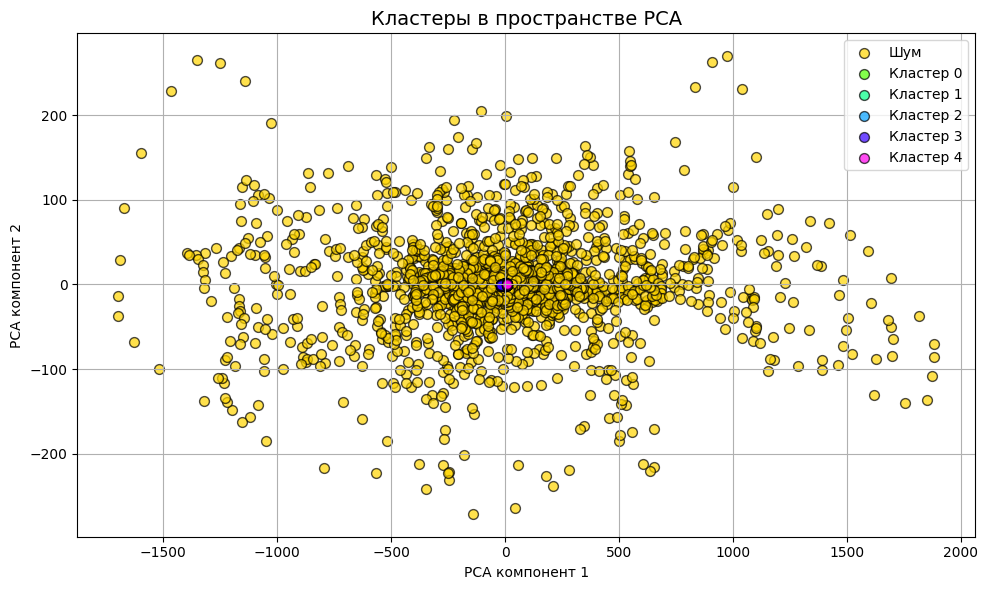

In [84]:
unique_clusters = np.unique(clusters_dbs)

# Палитра (используем seaborn для наглядности)
palette = sns.color_palette("hsv", len(unique_clusters))

plt.figure(figsize=(10, 6))

for idx, cluster_id in enumerate(unique_clusters):
    mask = clusters_dbs == cluster_id
    label = f"Кластер {cluster_id}" if cluster_id != -1 else "Шум"
    color = palette[idx]

    plt.scatter(
        features_pca[mask, 0],
        features_pca[mask, 1],
        s=50,
        label=label,
        color=color,
        edgecolor='k',
        alpha=0.7
    )

plt.title("Кластеры в пространстве PCA", fontsize=14)
plt.xlabel("PCA компонент 1")
plt.ylabel("PCA компонент 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [88]:
periods = []

y = cycle_d3_d5  # твой сигнал (после взвешивания компонент D3–D5)
t = np.arange(len(y))

for cluster_id in np.unique(clusters_dbs):
    if cluster_id == -1:
        continue  # пропускаем шум

    # Индексы всех точек этого кластера
    mask = clusters_dbs == cluster_id
    cluster_indices = np.where(mask)[0]

    # Значения сигнала и времени в этом кластере
    y_cluster = y[cluster_indices]
    t_cluster = t[cluster_indices]

    # Поиск пиков
    peaks, _ = find_peaks(y_cluster, distance=30)
    
    # Вычисляем периоды между пиками
    if len(peaks) > 1:
        period = np.mean(np.diff(t_cluster[peaks]))
    else:
        period = np.nan

    periods.append((cluster_id, len(cluster_indices), period))

# Вывод
for cid, count, per in periods:
    print(f"Кластер {cid}: элементов = {count}, средний период между пиками = {per:.1f} дней")

Кластер 0: элементов = 587, средний период между пиками = 125.2 дней
Кластер 1: элементов = 14, средний период между пиками = nan дней
Кластер 2: элементов = 10, средний период между пиками = nan дней
Кластер 3: элементов = 20, средний период между пиками = nan дней
Кластер 4: элементов = 15, средний период между пиками = nan дней


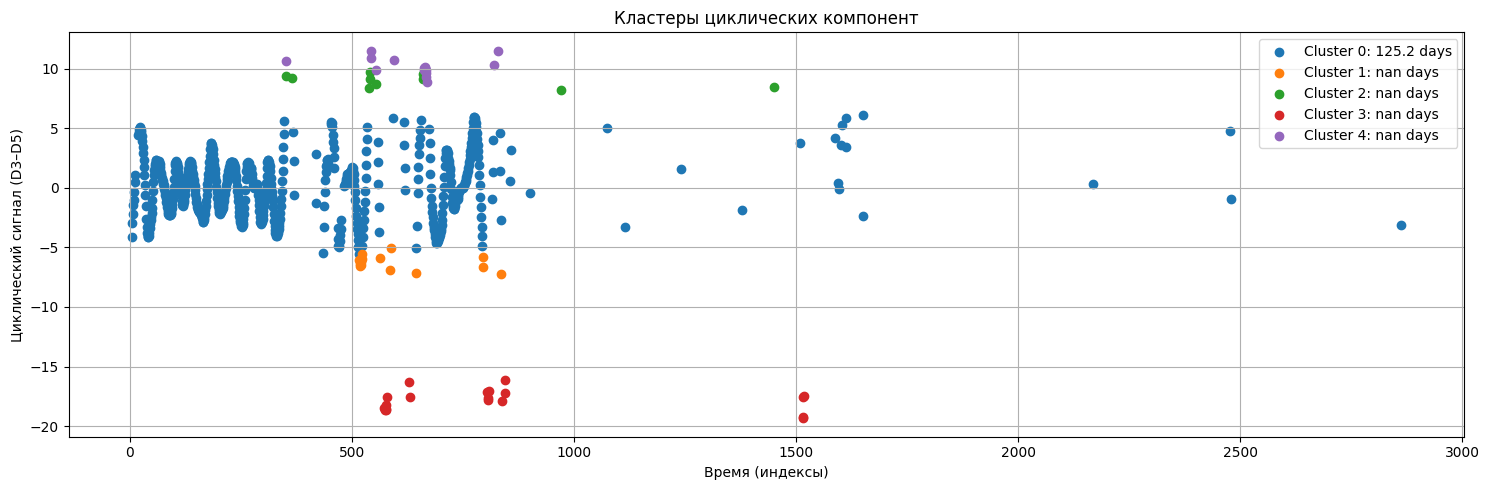

In [90]:
plt.figure(figsize=(15, 5))

# Предполагаем, что periods = [(cluster_id, count, period), ...]
for cluster_id, count, period in periods:
    if cluster_id == -1:
        continue  # пропускаем шум DBSCAN

    mask = clusters_dbs == cluster_id
    indices = np.where(mask)[0]
    values = cycle_d3_d5[mask]

    plt.scatter(indices, values, label=f'Cluster {cluster_id}: {period:.1f} days')

plt.title('Кластеры циклических компонент')
plt.xlabel('Время (индексы)')
plt.ylabel('Циклический сигнал (D3–D5)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


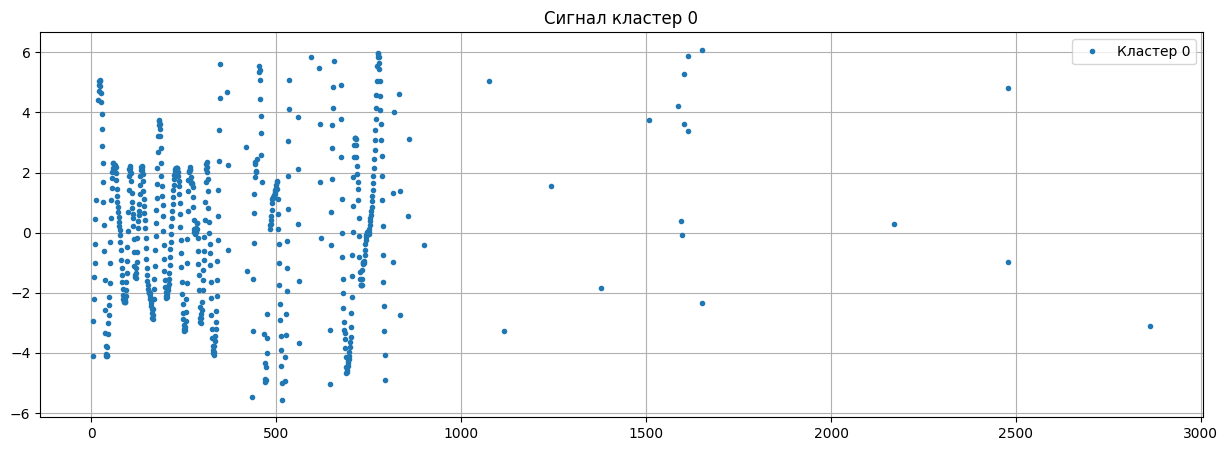

In [91]:
mask0 = clusters_dbs == 0
plt.figure(figsize=(15,5))
plt.plot(np.where(mask0)[0], cycle_d3_d5[mask0], '.', label="Кластер 0")
plt.title("Сигнал кластер 0")
plt.grid(True)
plt.legend()
plt.show()

## Попробуем сопоставить наш ряд с рядом индекса страха/жадности

### Вначале на кластере

In [116]:
fng_df = pd.read_csv("Greed.csv")
fng_df

date  value value_classification
0     2025-06-07     52              Neutral
1     2025-06-06     45                 Fear
2     2025-06-05     57                Greed
3     2025-06-04     62                Greed
4     2025-06-03     64                Greed
...          ...    ...                  ...
2675  2018-02-05     11         Extreme Fear
2676  2018-02-04     24         Extreme Fear
2677  2018-02-03     40                 Fear
2678  2018-02-02     15         Extreme Fear
2679  2018-02-01     30                 Fear

[2680 rows x 3 columns]

In [105]:
time_series= pd.read_excel("bitcoin.xlsx")
time_series = time_series.sort_values('Дата', ignore_index=True)

2610 2610


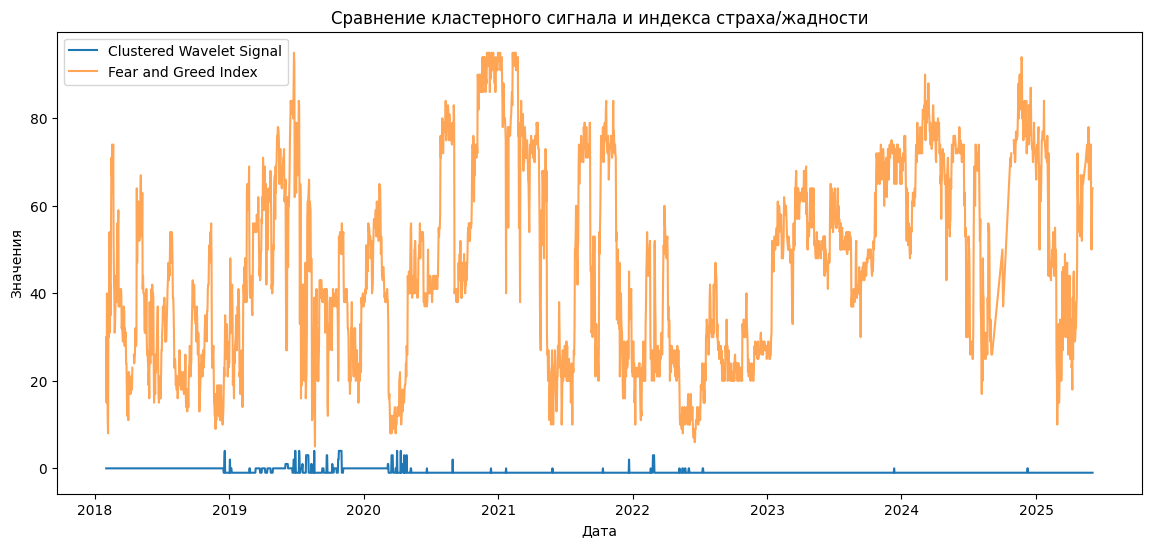

Корреляция: -0.164


In [118]:
#Обрезаем исходный временной ряд по дате (2018 и позже)
time_series_filtered = time_series[time_series['Дата'] >= fng_df['date'].min()].reset_index(drop=True)

start_date = time_series_filtered['Дата'].iloc[0]

# Найдем индекс в оригинальном ряде по дате
start_idx = time_series.index.get_loc(time_series[time_series['Дата'] == start_date].index[0])

clusters_dbs_filtered = clusters_dbs[start_idx : start_idx + len(time_series_filtered)]

merged_series = time_series_filtered.copy()
merged_series['cluster_signal'] = clusters_dbs_filtered

# Приводим колонки к datetime
merged_series['Дата'] = pd.to_datetime(merged_series['Дата'], errors='coerce')
fng_df['date'] = pd.to_datetime(fng_df['date'], errors='coerce')

# Переименовываем колонку с индексом страха/жадности
fng_df = fng_df.rename(columns={'value': 'fear_greed_value'})

# Выполняем merge по дате с разными именами колонок
merged = pd.merge(
    merged_series,
    fng_df[['date','fear_greed_value']],
    left_on='Дата',
    right_on='date',
    how='left'
).drop(columns=['date'])

# Проверяем
print(len(merged_series), len(merged))

# Визуализация и корреляция

plt.figure(figsize=(14,6))
plt.plot(merged['Дата'], merged['cluster_signal'], label='Clustered Wavelet Signal')
plt.plot(merged['Дата'], merged['fear_greed_value'], label='Fear and Greed Index', alpha=0.7)
plt.legend()
plt.title('Сравнение кластерного сигнала и индекса страха/жадности')
plt.xlabel('Дата')
plt.ylabel('Значения')
plt.show()

corr = merged['cluster_signal'].corr(merged['fear_greed_value'])
print(f'Корреляция: {corr:.3f}')

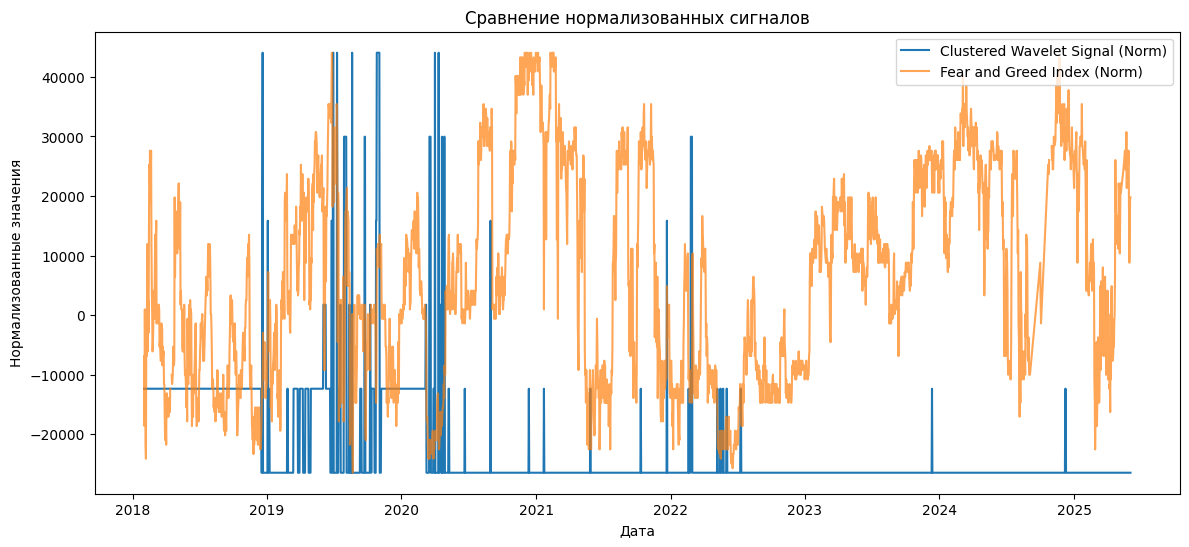

In [119]:
merged['cluster_signal_norm'] = scaler.fit_transform(merged[['cluster_signal']])
merged['fear_greed_value_norm'] = scaler.fit_transform(merged[['fear_greed_value']])

plt.figure(figsize=(14,6))
plt.plot(merged['Дата'], merged['cluster_signal_norm'], label='Clustered Wavelet Signal (Norm)')
plt.plot(merged['Дата'], merged['fear_greed_value_norm'], label='Fear and Greed Index (Norm)', alpha=0.7)
plt.legend()
plt.title('Сравнение нормализованных сигналов')
plt.xlabel('Дата')
plt.ylabel('Нормализованные значения')
plt.show()

### На кластере получилось откровенно никак. 

## Попробуем на детрендированном сигнале

In [121]:
fng_df

date  fear_greed_value value_classification
0    2025-06-07                52              Neutral
1    2025-06-06                45                 Fear
2    2025-06-05                57                Greed
3    2025-06-04                62                Greed
4    2025-06-03                64                Greed
...         ...               ...                  ...
2675 2018-02-05                11         Extreme Fear
2676 2018-02-04                24         Extreme Fear
2677 2018-02-03                40                 Fear
2678 2018-02-02                15         Extreme Fear
2679 2018-02-01                30                 Fear

[2680 rows x 3 columns]

In [ ]:
## Т.к идексы только 2018 года налдо подрезать наш сигнал

In [132]:
start_date = pd.to_datetime('2018-01-01')

# Фильтрация временного ряда биткоина (time_series, assumed с колонкой 'Дата')
btc_filtered = time_series[time_series['Дата'] >= start_date].reset_index(drop=True)
btc_filtered = btc_filtered["Значение"].values

# Аналогично для fng_df (у fng_df есть колонка 'date' в datetime)
fng_filtered = fng_df[fng_df['date'] >= start_date].reset_index(drop=True)
fng_df_emd = fng_filtered["fear_greed_value"].values

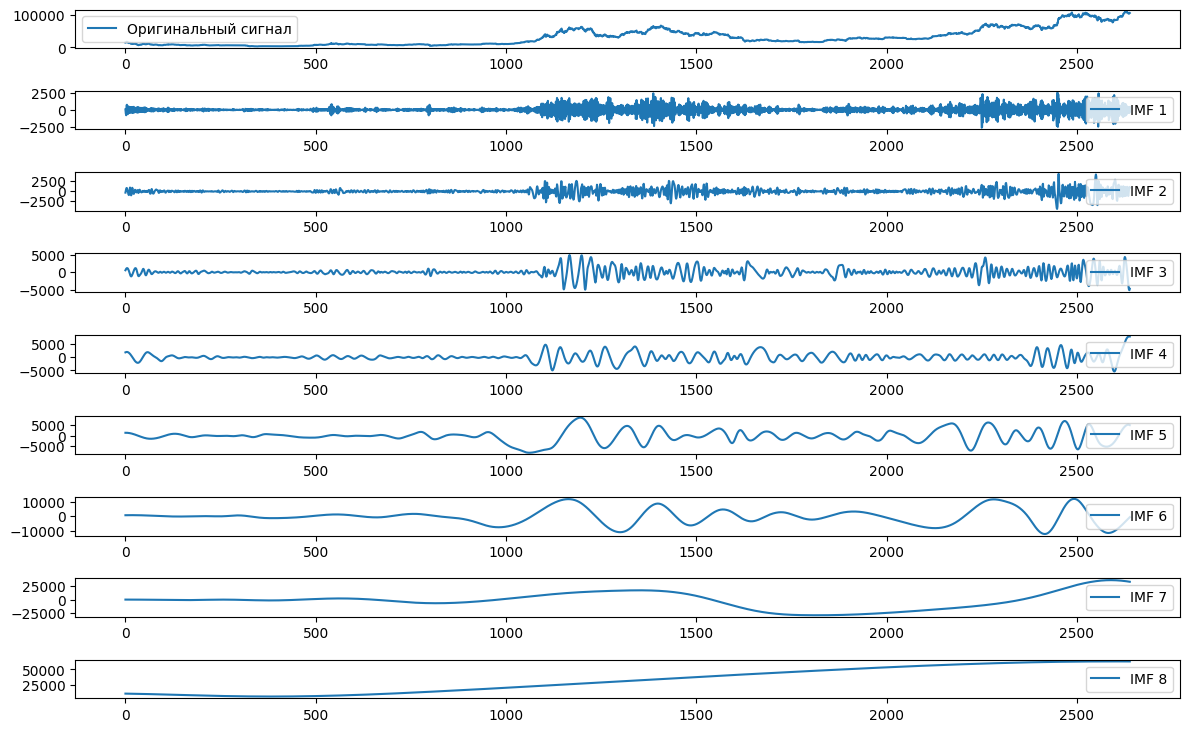

In [134]:
emd_filtered = EMD()
imfs_filtered = emd_filtered(btc_filtered)

# Визуализация
plt.figure(figsize=(12, 8))
plt.subplot(len(imfs_filtered)+2, 1, 1)
plt.plot(btc_filtered, label='Оригинальный сигнал')
plt.legend()

# Все IMFs
for i, imf in enumerate(imfs_filtered):
    plt.subplot(len(imfs_filtered)+2, 1, i+2)
    plt.plot(imf, label=f'IMF {i+1}')
    plt.legend()

plt.tight_layout() 

# Показываем график
plt.show()

In [136]:
possible_cycle_filtered = np.sum(imfs_filtered[3:6], axis=0)
possible_cycle_filtered = pd.Series(possible_cycle_filtered)

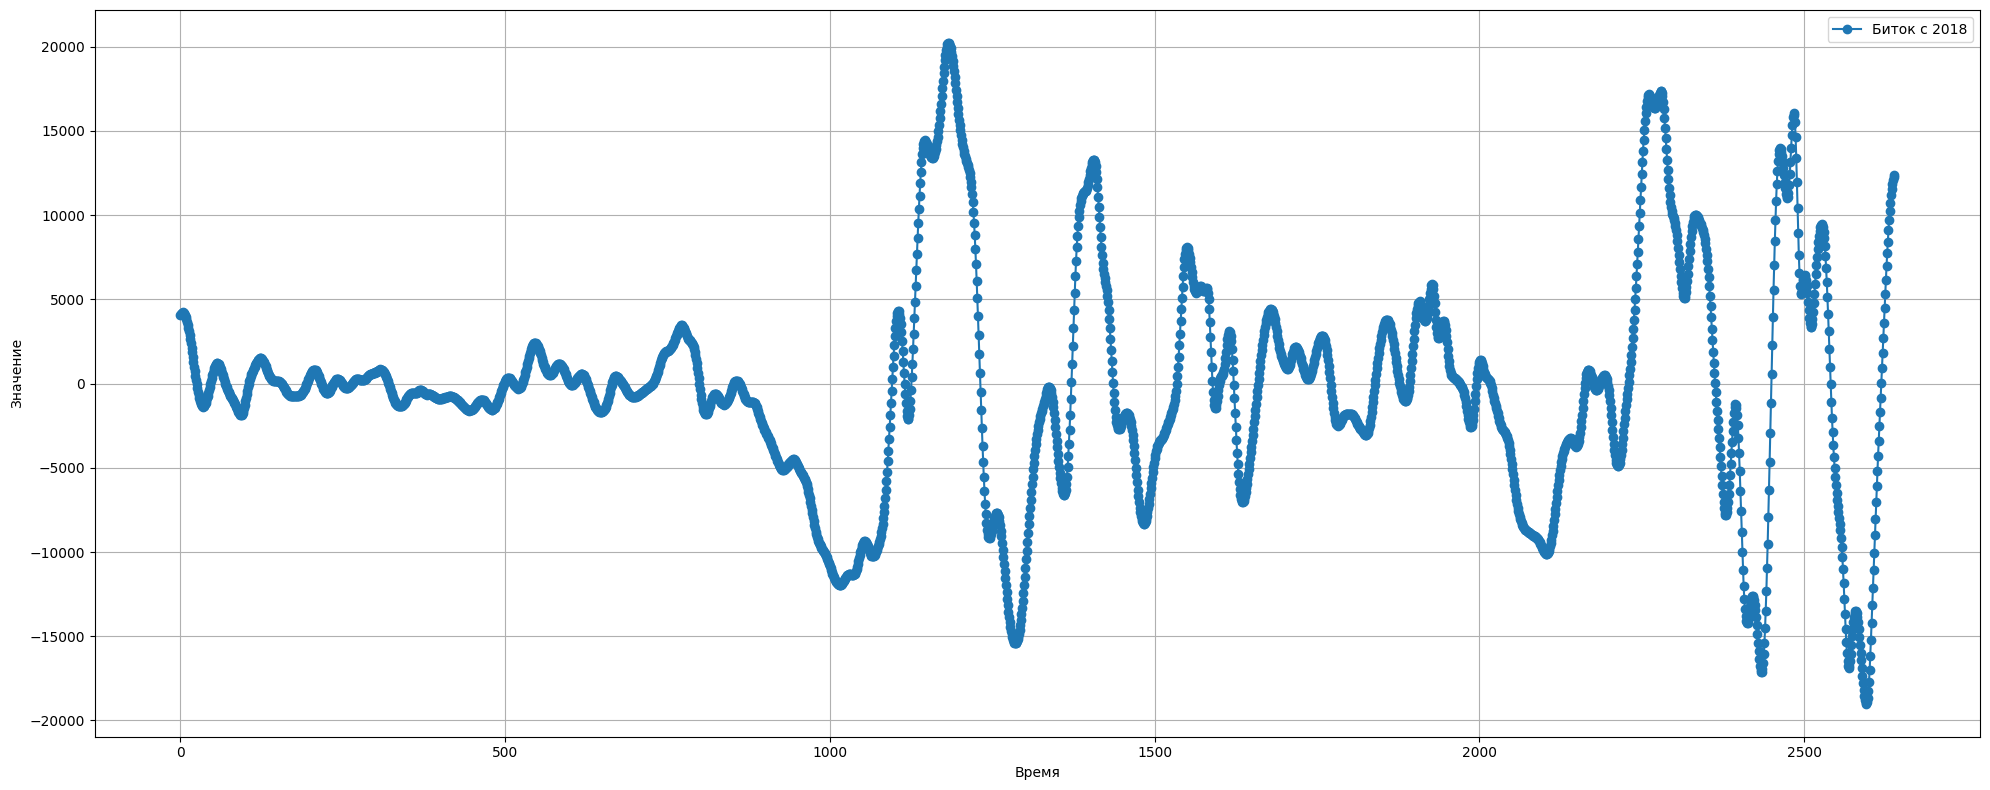

In [137]:
# Построение графика
plt.figure(figsize=(20, 8))
plt.plot(possible_cycle_filtered, marker='o', label="Биток с 2018")
plt.xlabel("Время")
plt.ylabel("Значение")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

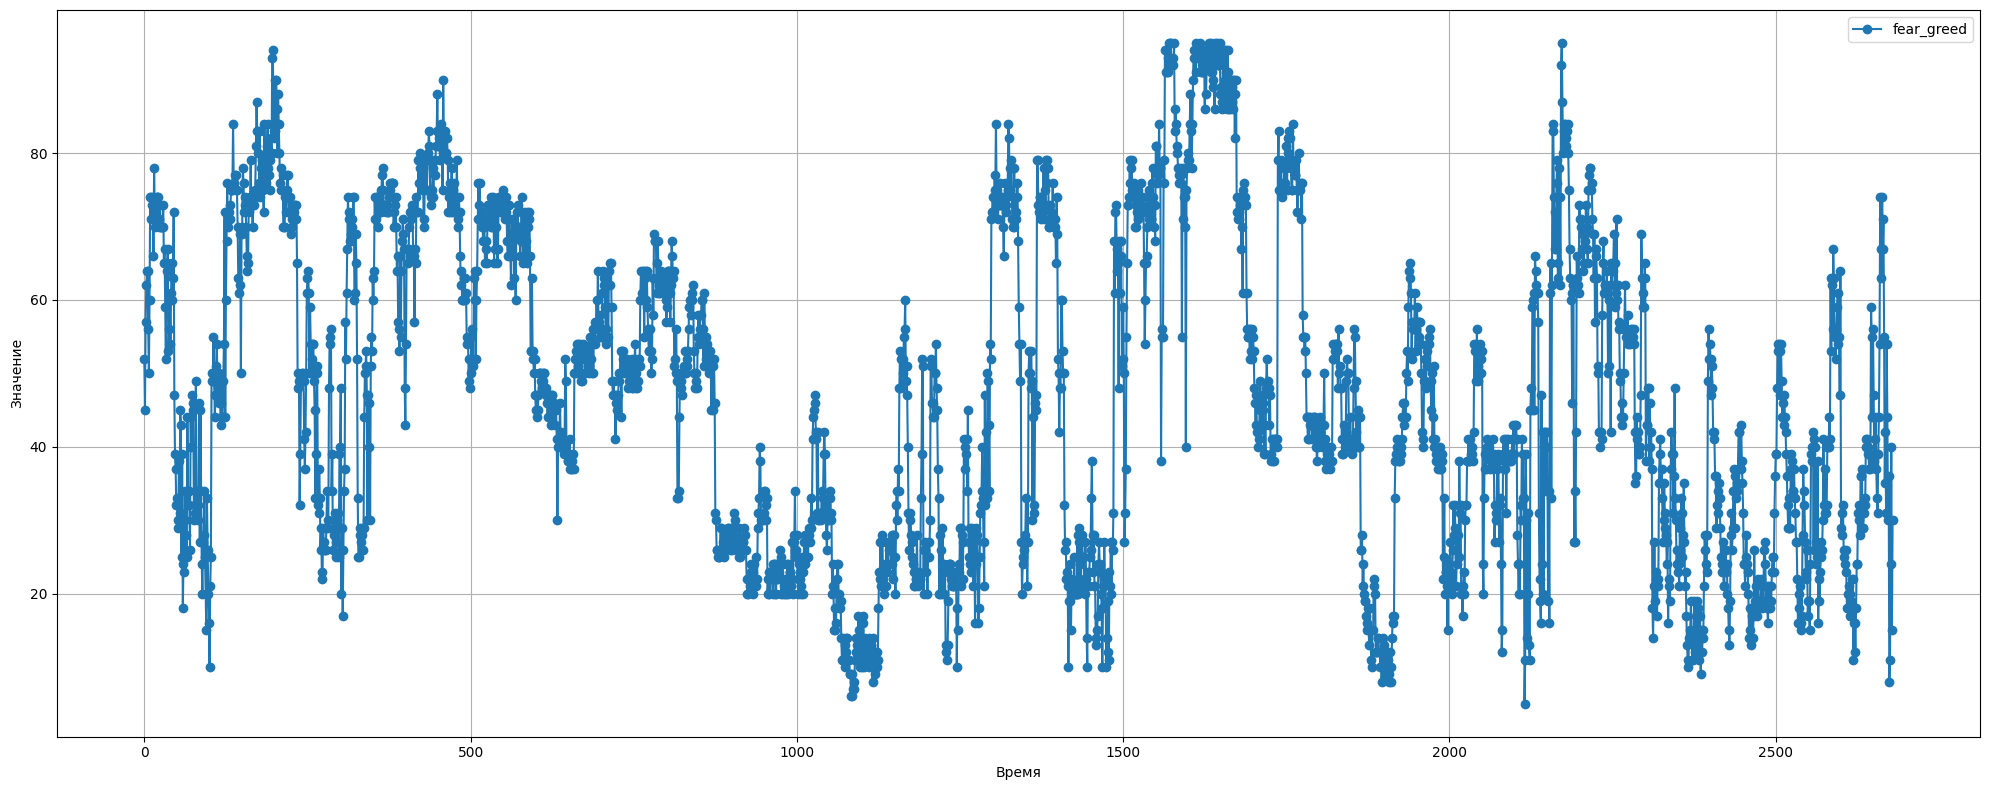

In [138]:
# Построение графика
plt.figure(figsize=(20, 8))
plt.plot(fng_df_emd, marker='o', label="fear_greed")
plt.xlabel("Время")
plt.ylabel("Значение")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

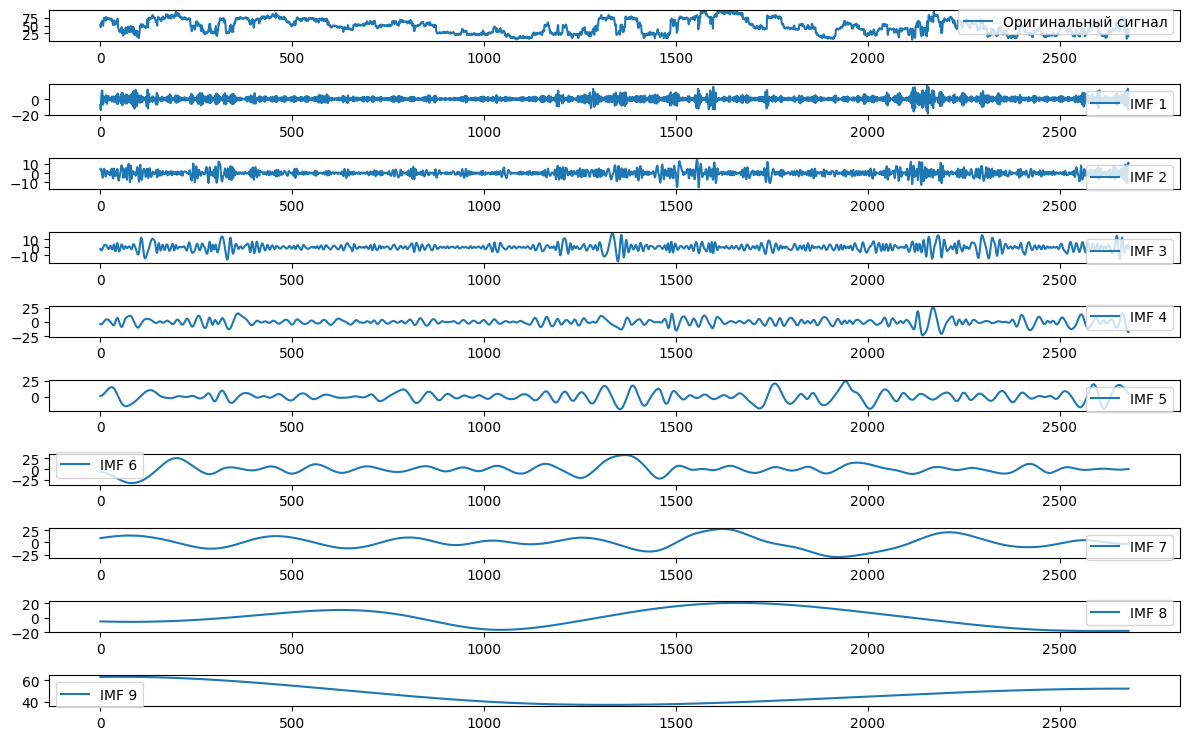

In [139]:
emd_fng = EMD()
imfs_fng = emd_fng(fng_df_emd)

# Визуализация
plt.figure(figsize=(12, 8))
plt.subplot(len(imfs_fng)+2, 1, 1)
plt.plot(fng_df_emd, label='Оригинальный сигнал')
plt.legend()

# Все IMFs
for i, imf in enumerate(imfs_fng):
    plt.subplot(len(imfs_fng)+2, 1, i+2)
    plt.plot(imf, label=f'IMF {i+1}')
    plt.legend()

plt.tight_layout()  # Чтобы графики не налезали друг на друга

# Показываем график в ноутбуке
plt.show()

Допустим что 1-2 сигнала - шумы а 8-9 скорее всего тренд попробуем собратьс игнал без них

In [140]:
fng_df_after_emd= np.sum(imfs_fng[3:7], axis=0)
fng_df_after_emd = pd.Series(fng_df_after_emd)

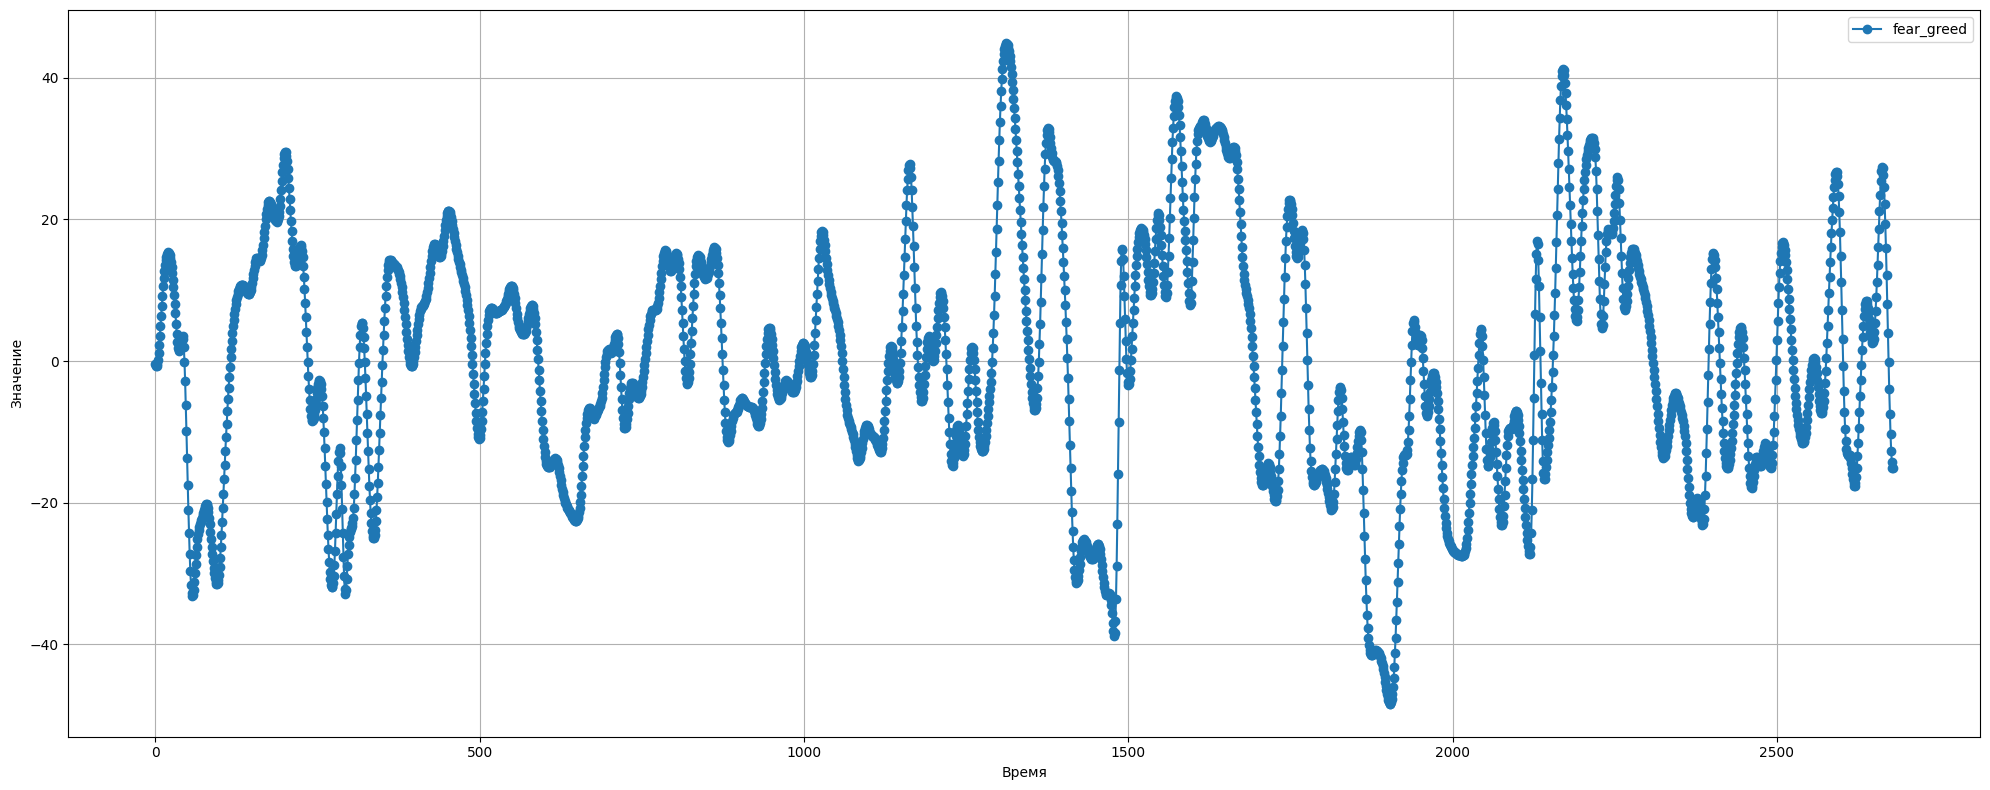

In [141]:
# Построение графика
plt.figure(figsize=(20, 8))
plt.plot(fng_df_after_emd, marker='o', label="fear_greed")
plt.xlabel("Время")
plt.ylabel("Значение")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [144]:
def standardize(x):
    return (x - np.mean(x)) / np.std(x)

possible_cycle_scaled = standardize(possible_cycle_filtered)
fng_df_scaled = standardize(fng_df_after_emd)


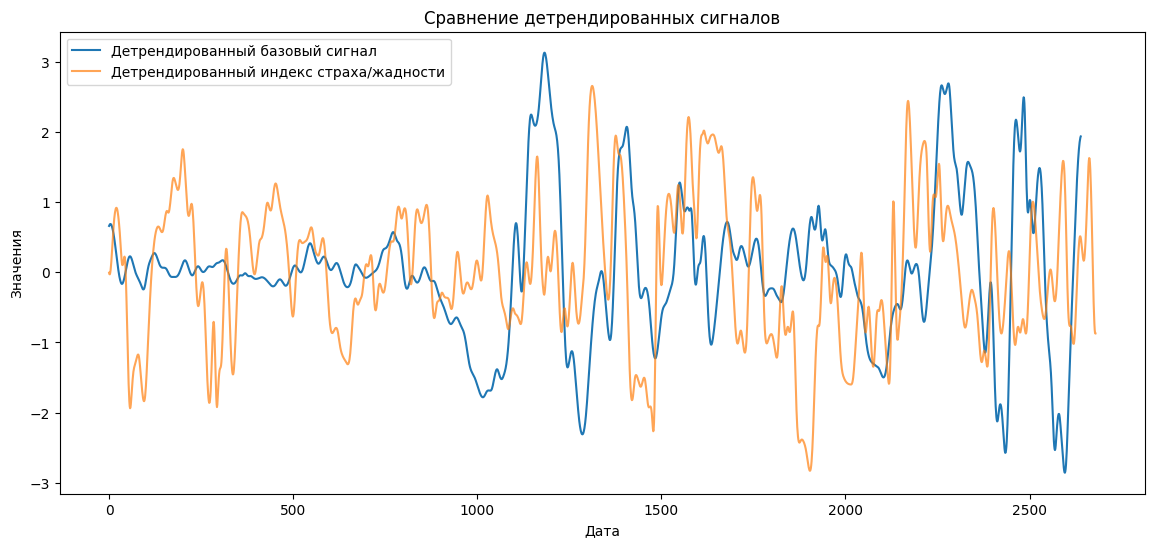

In [145]:
# Визуализация
plt.figure(figsize=(14,6))
plt.plot(possible_cycle_scaled, label='Детрендированный базовый сигнал')
plt.plot(fng_df_scaled, label='Детрендированный индекс страха/жадности', alpha=0.7)
plt.legend()
plt.title('Сравнение детрендированных сигналов')
plt.xlabel('Дата')
plt.ylabel('Значения')
plt.show()


In [147]:
# Корреляция
min_len = min(len(possible_cycle_scaled), len(fng_df_scaled))

x = possible_cycle_scaled[:min_len]
y = fng_df_scaled[:min_len]

corr_filtered = np.corrcoef(x, y)[0,1]
print(f'Корреляция детрендированных сигналов: {corr_filtered:.3f}')

Корреляция детрендированных сигналов: 0.073


In [148]:
freqs, power = periodogram(fng_df_scaled)
dominant_freq_index = np.argmax(power[1:]) + 1  # пропускаем нулевую частоту
dominant_freq = freqs[dominant_freq_index]
seasonal_period_fng_df = int(round(1 / dominant_freq))

seasonal_period_fng_df

298

In [149]:
y = fng_df_scaled
t = np.arange(1, len(y) + 1)  # т.к. индекс начинается с 1

min_freq = 1/100  # например, максимум период 100 шагов
max_freq = 1/2   # минимум период 2 шага (Nyquist)
frequency, power = LombScargle(t, y).autopower(minimum_frequency=min_freq, maximum_frequency=max_freq)
best_freq = frequency[np.argmax(power)]
best_period = 1 / best_freq
print(f"Best frequency: {best_freq:.4f}")
print(f"Best period: {best_period:.2f}")

Best frequency: 0.0110
Best period: 91.15


In [156]:
x = possible_cycle_scaled[:min_len]
y = fng_df_scaled[:min_len]

spearman_corr, spearman_p = spearmanr(x, y)
print(f"Spearman correlation: {spearman_corr:.3f}, p-value: {spearman_p:.3f}")

Spearman correlation: 0.095, p-value: 0.000


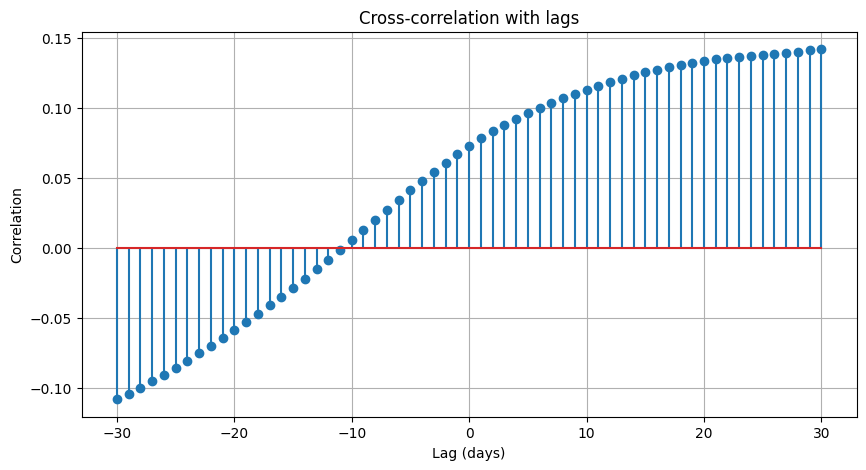

Max cross-correlation: 0.142 at lag 30 days


In [162]:

def cross_correlation(z, t, max_lag):
    lags = np.arange(-max_lag, max_lag + 1)
    corr = []
    n = len(z)
    for lag in lags:
        if lag < 0:
            # сдвигаем t влево, z берём с начала с учётом смещения lag
            z_slice = z[:n+lag]
            t_slice = t[-lag:n]
        elif lag > 0:
            # сдвигаем t вправо, z берём с конца с учётом смещения lag
            z_slice = z[lag:n]
            t_slice = t[:n-lag]
        else:
            z_slice = z
            t_slice = t
        if len(z_slice) > 0 and len(t_slice) > 0:
            corr_val = np.corrcoef(z_slice, t_slice)[0,1]
        else:
            corr_val = np.nan
        corr.append(corr_val)
    return lags, corr

max_lag = 30
lags, corr_values = cross_correlation(x, y, max_lag)

plt.figure(figsize=(10,5))
plt.stem(lags, corr_values)
plt.title("Cross-correlation with lags")
plt.xlabel("Lag (days)")
plt.ylabel("Correlation")
plt.grid()
plt.show()

# Уберём nan и найдём максимум по абсолютному значению
valid_corr = [(abs(c), l) for c, l in zip(corr_values, lags) if not np.isnan(c)]
max_corr, best_lag = max(valid_corr, key=lambda item: item[0])
print(f"Max cross-correlation: {max_corr:.3f} at lag {best_lag} days")

In [160]:
def mutual_info(x, y, bins=20):
    c_xy = np.histogram2d(x, y, bins)[0]
    mi = mutual_info_score(None, None, contingency=c_xy)
    return mi

mi = mutual_info(x, y)
print(f"Mutual Information: {mi:.3f}")

Mutual Information: 0.260


Max Lag | Max Corr | Lag at Max Corr
     10 |    0.118 |             -10
     20 |    0.142 |             -20
     30 |    0.147 |             -24
     40 |    0.156 |             -20
     50 |    0.160 |             -17
     60 |    0.159 |             -17
     70 |    0.177 |             -70
     80 |    0.177 |             -62
     90 |    0.175 |             -61
    100 |    0.175 |             -61
    110 |    0.178 |             -61
    120 |    0.187 |             -61
    130 |    0.192 |             -60
    140 |    0.192 |             -60
    150 |    0.196 |             -61
    160 |    0.208 |             -61
    170 |    0.213 |             -59
    180 |    0.210 |             -57
    190 |    0.209 |             -60
    200 |    0.203 |             -62
    210 |    0.193 |             -78
    220 |    0.192 |             -79
    230 |   -0.193 |              44
    240 |   -0.195 |              46
    250 |   -0.196 |              46
    260 |   -0.201 |              45


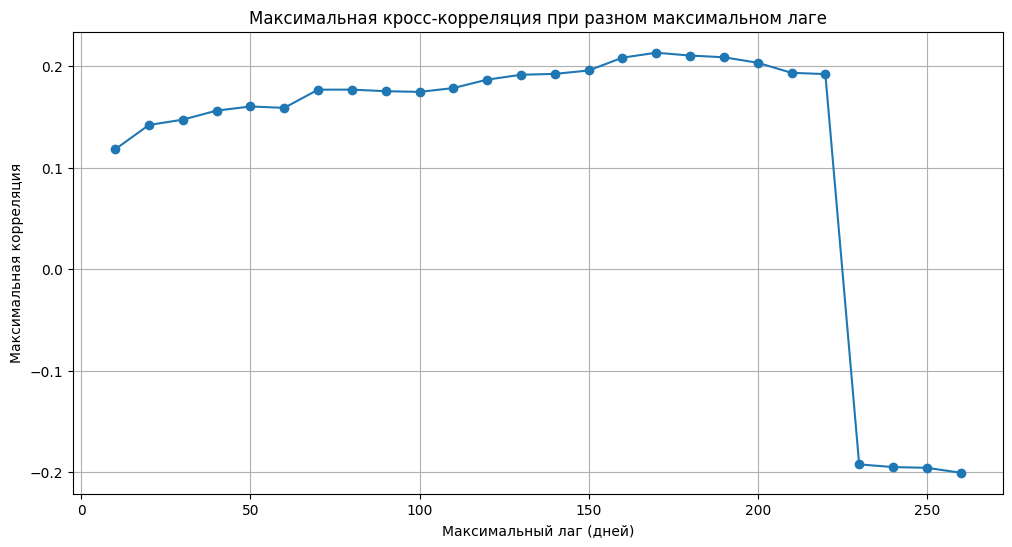

In [163]:
def cross_correlation(z, t, max_lag):
    lags = np.arange(-max_lag, max_lag + 1)
    corr = []
    for lag in lags:
        # Берём общую длину среза для z и t с учётом лага
        start_idx_z = max_lag
        end_idx_z = len(z) - max_lag
        start_idx_t = max_lag + lag
        end_idx_t = len(t) - max_lag + lag

        if start_idx_t < 0 or end_idx_t > len(t):
            # Если индекс выходит за границы, пропускаем
            continue

        corr_val = np.corrcoef(z[start_idx_z:end_idx_z], t[start_idx_t:end_idx_t])[0, 1]
        corr.append((lag, corr_val))

    return corr

max_lag_min = 10
max_lag_max = 260
step = 10

results = []

for ml in range(max_lag_min, max_lag_max + 1, step):
    corr_vals = cross_correlation(x, y, ml)
    if not corr_vals:
        continue
    lags, corrs = zip(*corr_vals)
    max_corr = max(corrs, key=abs)
    best_lag = lags[corrs.index(max_corr)]
    results.append((ml, max_corr, best_lag))

# Вывод результатов
print("Max Lag | Max Corr | Lag at Max Corr")
for ml, mc, bl in results:
    print(f"{ml:7} | {mc:8.3f} | {bl:15}")

# Визуализация
lags_list = [r[0] for r in results]
max_corrs_list = [r[1] for r in results]

plt.figure(figsize=(12,6))
plt.plot(lags_list, max_corrs_list, marker='o')
plt.title('Максимальная кросс-корреляция при разном максимальном лаге')
plt.xlabel('Максимальный лаг (дней)')
plt.ylabel('Максимальная корреляция')
plt.grid(True)
plt.show()

Вот что видно из данных:
Максимальная кросс-корреляция растёт с увеличением максимального лага до примерно 170 дней (пик около 0.213 при лаге около -59 дней).
После примерно 220 дней корреляция резко меняет знак и становится отрицательной (примерно -0.19…-0.20 при лагах около +44…+46 дней).
Интерпретация
Отрицательные лаги (например, -59 дней) означают, что сигнал y (FNG индекс) опережает сигнал x (possible_cycle) на эти дни. То есть индекс страха/жадности, вероятно, влияет или предвосхищает циклические колебания биткоина с задержкой около 2 месяцев.
Положительные лаги (около +45 дней) — наоборот, биткоин опережает индекс.

### Интересные наблюдения 
Циклы из кластеризации и вейвлет-декомпозиции — около 57 и 48 дней.
Лаги с максимальной корреляцией — примерно -59 и +46 дней.
Такое согласование говорит о том, что в данных действительно есть устойчивые циклические компоненты с периодами около 50–60 дней, и именно на этих масштабах индекс страха/жадности и биткоин взаимодействуют сильнее всего.
Это усиливает гипотезу, что индекс FNG отражает именно те временные циклы, которые есть в биткоине, но с некоторой задержкой (или опережением). Значит, индекс может быть полезен как индикатор на горизонте около 2 месяцев.

Max Lag | Max Corr | Lag at Max Corr
     10 |    0.118 |             -10
     20 |    0.142 |             -20
     30 |    0.147 |             -24
     40 |    0.156 |             -20
     50 |    0.160 |             -17
     60 |    0.159 |             -17
     70 |    0.177 |             -70
     80 |    0.177 |             -62
     90 |    0.175 |             -61
    100 |    0.175 |             -61
    110 |    0.178 |             -61
    120 |    0.187 |             -61
    130 |    0.192 |             -60
    140 |    0.192 |             -60
    150 |    0.196 |             -61
    160 |    0.208 |             -61
    170 |    0.213 |             -59
    180 |    0.210 |             -57
    190 |    0.209 |             -60
    200 |    0.203 |             -62
    210 |    0.193 |             -78
    220 |    0.192 |             -79
    230 |   -0.193 |              44
    240 |   -0.195 |              46
    250 |   -0.196 |              46
    260 |   -0.201 |              45
 

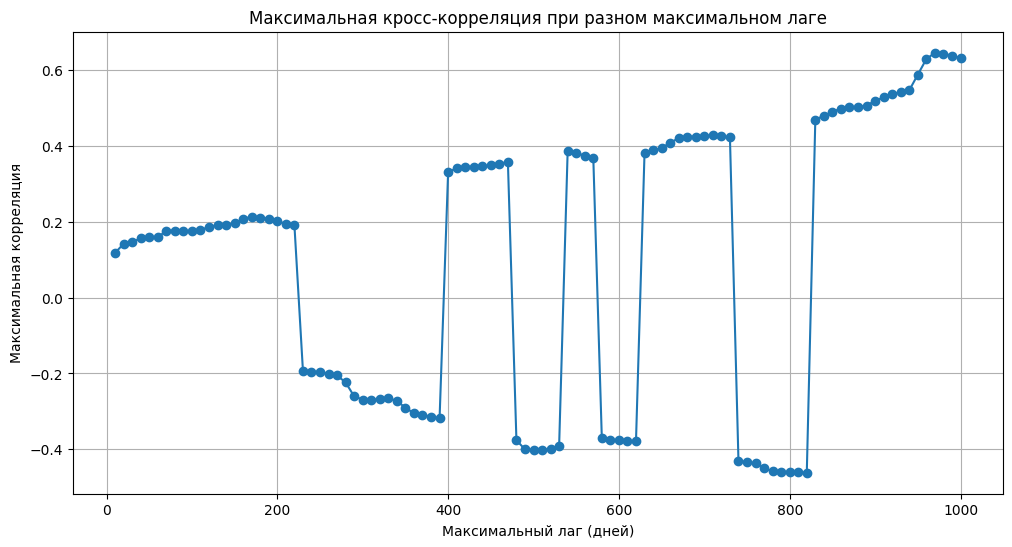

In [166]:
def cross_correlation(z, t, max_lag):
    lags = np.arange(-max_lag, max_lag + 1)
    corr = []
    for lag in lags:
        # Берём общую длину среза для z и t с учётом лага
        start_idx_z = max_lag
        end_idx_z = len(z) - max_lag
        start_idx_t = max_lag + lag
        end_idx_t = len(t) - max_lag + lag

        if start_idx_t < 0 or end_idx_t > len(t):
            # Если индекс выходит за границы, пропускаем
            continue

        corr_val = np.corrcoef(z[start_idx_z:end_idx_z], t[start_idx_t:end_idx_t])[0, 1]
        corr.append((lag, corr_val))

    return corr

max_lag_min = 10
max_lag_max = 1000
step = 10

results2 = []

for ml in range(max_lag_min, max_lag_max + 1, step):
    corr_vals = cross_correlation(x, y, ml)
    if not corr_vals:
        continue
    lags, corrs = zip(*corr_vals)
    max_corr = max(corrs, key=abs)
    best_lag = lags[corrs.index(max_corr)]
    results2.append((ml, max_corr, best_lag))

# Вывод результатов
print("Max Lag | Max Corr | Lag at Max Corr")
for ml, mc, bl in results2:
    print(f"{ml:7} | {mc:8.3f} | {bl:15}")

# Визуализация
lags_list = [r[0] for r in results2]
max_corrs_list = [r[1] for r in results2]

plt.figure(figsize=(12,6))
plt.plot(lags_list, max_corrs_list, marker='o')
plt.title('Максимальная кросс-корреляция при разном максимальном лаге')
plt.xlabel('Максимальный лаг (дней)')
plt.ylabel('Максимальная корреляция')
plt.grid(True)
plt.show()

### Интересные наблюдения 2
1. Локальный максимум вблизи -60 дней
В интервале ~130–200 лагов:
Пик корреляции ~0.213 при лаге -59.

Это совпадает с вейвлет-кластерами 57 и 48 дней, причём лаги указывают на то, что FNG предсказывает биткоин примерно за 2 месяца.

2. Вторая группа пиков: около +46 дней
В интервале 230–270 лагов:

Наблюдается инвертированная (отрицательная) корреляция: -0.201 при лаге +45…+46.
Это может указывать на реакцию рынка на поведение FNG с запозданием — либо другой фазовый сдвиг в цикле.

3. Глобальный максимум: ~+0.64 при лаге -374…-383
Это очень сильная положительная корреляция:
Лаг ~-370 дней означает, что информация из FNG на год раньше хорошо коррелирует с текущим BTC.

Возможные причины:
Годовые сезонные паттерны в поведении толпы?
Или циклический ритм рынка, повторяющийся каждые ~365 дней?

4. Сильная отрицательная корреляция при лаге +300
Лаг +296…+304 → корреляция -0.46

Опять же, это может быть зеркальный цикл, где рынок инвертирует поведение толпы почти ровно через год.



| Источник         | Период (дней)  | Контекст                            |
| ---------------- | -------------- | ----------------------------------- |
| Вейвлет-кластеры | 57, 48         | Циклы из энергии частот             |
| Кросс-корреляция | \~59, \~46     | Лаги с max корреляцией              |
| Кросс-корреляция | \~365          | Максимальная корреляция по модулю   |
| EMD-циклы        | IMF4–IMF6      | Циклические компоненты \~50–60 дней |
| BTC-халвинги     | 1450 / 4 ≈ 360 | Средняя длина рыночного цикла       |


###  Granger Causality Test (тест причинности по Грейнджеру) позволит нам оценить, предсказывает ли FNG поведение BTC (а не просто коррелирует с ним).

🧪 Что делает тест Грейнджера?
Он проверяет: добавление прошедших значений одного временного ряда (FNG) улучшает ли предсказание текущего значения другого ряда (BTC).
Если да, то говорят, что FNG Granger-вызывает BTC.
⚙️ Что нужно:
2 временных ряда одинаковой длины — FNG и BTC.
Проверка на стационарность (тест ADF).
Выровнять по времени (lag-выравнивание) и удалить пропуски.


In [168]:
x = possible_cycle_scaled[:min_len]
y = fng_df_scaled[:min_len]

# 1. Объединяем в DataFrame
df = pd.DataFrame({'btc': x, 'fng': y})

# 2. Проверим на стационарность (перед Granger обязательно)
def adf_test(series, title=''):
    result = adfuller(series, autolag='AIC')
    print(f'ADF Statistic ({title}): {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print('Stationary' if result[1] < 0.05 else 'Non-stationary')

adf_test(df['fng'], 'FNG')
adf_test(df['btc'], 'BTC')

# 3. Если нестационарны — применим разности
df_diff = df.diff().dropna()

# 4. Granger test: FNG → BTC
max_lag = 60  # Можно подобрать по AIC/BIC, но сначала вручную
print("\nGranger Causality Test: Does FNG → BTC?")
grangercausalitytests(df_diff[['btc', 'fng']], maxlag=max_lag, verbose=True)

ADF Statistic (FNG): -5.3694
p-value: 0.0000
Stationary
ADF Statistic (BTC): -6.0429
p-value: 0.0000
Stationary

Granger Causality Test: Does FNG → BTC?

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.5840  , p=0.1081  , df_denom=2635, df_num=1
ssr based chi2 test:   chi2=2.5870  , p=0.1077  , df=1
likelihood ratio test: chi2=2.5857  , p=0.1078  , df=1
parameter F test:         F=2.5840  , p=0.1081  , df_denom=2635, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2430  , p=0.7843  , df_denom=2632, df_num=2
ssr based chi2 test:   chi2=0.4870  , p=0.7839  , df=2
likelihood ratio test: chi2=0.4869  , p=0.7839  , df=2
parameter F test:         F=0.2430  , p=0.7843  , df_denom=2632, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.2844  , p=0.0770  , df_denom=2629, df_num=3
ssr based chi2 test:   chi2=6.8716  , p=0.0761  , df=3
likelihood ratio test: chi2=6.8626  , p=0.0764  , df=3
parameter

{1: ({'ssr_ftest': (2.584013186579739, 0.10806747292897678, 2635.0, 1),
   'ssr_chi2test': (2.5869551370767936, 0.10774729025100913, 1),
   'lrtest': (2.585687516751932, 0.10783357727589739, 1),
   'params_ftest': (2.584013186580569, 0.10806747292889275, 2635.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (0.24303174309529854, 0.7842642161863056, 2632.0, 2),
   'ssr_chi2test': (0.48698685907469774, 0.7838846265000137, 2),
   'lrtest': (0.4869418975576991, 0.7839022490190763, 2),
   'params_ftest': (0.24303174309395748, 0.7842642161873368, 2632.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (2.2844347386941206, 0.07698228181730915, 2629.0, 3),
   'ssr_chi2test': (6.871551888015635, 0.0761065141789502, 3),
   'lrtest': (6.862611006727093, 0.07640816808453525, 3),
   'params_ftest': (2.2844347386928376, 0.07698228181745592, 2629.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0

In [169]:
grangercausalitytests(df_diff[['fng','btc']], maxlag=max_lag, verbose=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8244  , p=0.3640  , df_denom=2635, df_num=1
ssr based chi2 test:   chi2=0.8253  , p=0.3636  , df=1
likelihood ratio test: chi2=0.8252  , p=0.3637  , df=1
parameter F test:         F=0.8244  , p=0.3640  , df_denom=2635, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.3664  , p=0.0940  , df_denom=2632, df_num=2
ssr based chi2 test:   chi2=4.7417  , p=0.0934  , df=2
likelihood ratio test: chi2=4.7375  , p=0.0936  , df=2
parameter F test:         F=2.3664  , p=0.0940  , df_denom=2632, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.2076  , p=0.3054  , df_denom=2629, df_num=3
ssr based chi2 test:   chi2=3.6324  , p=0.3040  , df=3
likelihood ratio test: chi2=3.6299  , p=0.3043  , df=3
parameter F test:         F=1.2076  , p=0.3054  , df_denom=2629, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.5755  , p=0.

{1: ({'ssr_ftest': (0.8243523232672493, 0.3639937413903773, 2635.0, 1),
   'ssr_chi2test': (0.8252908648117661, 0.36363776874854103, 1),
   'lrtest': (0.8251617967762286, 0.3636752873470519, 1),
   'params_ftest': (0.8243523232663281, 0.3639937413906331, 2635.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (2.366373238438604, 0.09401995505828847, 2632.0, 2),
   'ssr_chi2test': (4.741737256658509, 0.0933995615270784, 2),
   'lrtest': (4.737479168819846, 0.09359862512799703, 2),
   'params_ftest': (2.3663732384376717, 0.09401995505838275, 2632.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (1.2075838770660092, 0.30541125136195096, 2629.0, 3),
   'ssr_chi2test': (3.6323976035899586, 0.30399218805459505, 3),
   'lrtest': (3.629897185586742, 0.30430153867716553, 3),
   'params_ftest': (1.2075838770678449, 0.3054112513611771, 2629.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0.,

Нет статистически значимой причинности при любом количестве лагов от 1 до 23 — ни один из p-value не ниже 0.05. Это означает, что предикторная переменная (X) не Granger-причиняет отклик (Y) (возможно, цену актива или другую метрику), по данным в этом виде.
📌 Возможные объяснения отсутствия причинности
- Нет реальной зависимости между временными рядами.
- Зависимость не линейная — тест Грейнджера основан на линейных регрессиях.


In [185]:
# Предположим, у нас есть твои ряды в x и y (нормализованные)
x = possible_cycle_scaled[:min_len]
y = fng_df_scaled[:min_len]

def discretize(series, bins=5):
    bin_edges = np.histogram_bin_edges(series, bins=bins)
    digits = np.digitize(series, bin_edges[1:], right=False)
    return digits

x_discrete = discretize(x)
y_discrete = discretize(y)

print(f"x_discrete min={x_discrete.min()}, max={x_discrete.max()}")
print(f"y_discrete min={y_discrete.min()}, max={y_discrete.max()}")

te_y_to_x = transfer_entropy(y_discrete.tolist(), x_discrete.tolist(), k=1)
te_x_to_y = transfer_entropy(x_discrete.tolist(), y_discrete.tolist(), k=1)

print(f"Transfer Entropy FNG → BTC: {te_y_to_x:.4f}")
print(f"Transfer Entropy BTC → FNG: {te_x_to_y:.4f}")

x_discrete min=0, max=5
y_discrete min=0, max=5
Transfer Entropy FNG → BTC: 0.0101
Transfer Entropy BTC → FNG: 0.0092


In [189]:
def permutation_test_te(source, target, k=1, n_permutations=1000, random_seed=42):
    np.random.seed(random_seed)
    real_te = transfer_entropy(source, target, k=k)
    permuted_tes = []
    for _ in range(n_permutations):
        permuted_source = np.random.permutation(source)
        te_perm = transfer_entropy(permuted_source.tolist(), target, k=k)
        permuted_tes.append(te_perm)
    permuted_tes = np.array(permuted_tes)
    
    # p-value: доля перестановок с TE >= реального TE
    p_value = np.mean(permuted_tes >= real_te)
    return real_te, p_value, permuted_tes

n_permutations = 500
# Пример для FNG → BTC
real_te, p_value, permuted_tes = permutation_test_te(y_discrete.tolist(), x_discrete.tolist(), k=1, n_permutations=n_permutations)

print(f"Real TE (FNG → BTC), premut {n_permutations}: {real_te:.4f}")
print(f"P-value: {p_value:.4f}")

real_te, p_value, permuted_tes = permutation_test_te(x_discrete.tolist(), y_discrete.tolist(), k=1, n_permutations=n_permutations)

print(f"Real TE ( BTC→ FNG), premut {n_permutations}: {real_te:.4f}")
print(f"P-value: {p_value:.4f}")

Real TE (FNG → BTC), premut 500: 0.0101
P-value: 0.4680
Real TE ( BTC→ FNG), premut 500: 0.0092
P-value: 0.7160


In [191]:
for per in range(50,1000,50):
    real_te, p_value, permuted_tes = permutation_test_te(y_discrete.tolist(), x_discrete.tolist(), k=1, n_permutations=per)

    print(f"Real TE (FNG → BTC), premut {per}: {real_te:.4f}")
    print(f"P-value: {p_value:.4f}")
    
    real_te, p_value, permuted_tes = permutation_test_te(x_discrete.tolist(), y_discrete.tolist(), k=1, n_permutations=per)
    
    print(f"Real TE ( BTC→ FNG), premut {per}: {real_te:.4f}")
    print(f"P-value: {p_value:.4f}")
        

Real TE (FNG → BTC), premut 50: 0.0101
P-value: 0.5600
Real TE ( BTC→ FNG), premut 50: 0.0092
P-value: 0.6600
Real TE (FNG → BTC), premut 100: 0.0101
P-value: 0.5200
Real TE ( BTC→ FNG), premut 100: 0.0092
P-value: 0.6700
Real TE (FNG → BTC), premut 150: 0.0101
P-value: 0.5067
Real TE ( BTC→ FNG), premut 150: 0.0092
P-value: 0.7000
Real TE (FNG → BTC), premut 200: 0.0101
P-value: 0.5300
Real TE ( BTC→ FNG), premut 200: 0.0092
P-value: 0.7050
Real TE (FNG → BTC), premut 250: 0.0101
P-value: 0.5080
Real TE ( BTC→ FNG), premut 250: 0.0092
P-value: 0.6920
Real TE (FNG → BTC), premut 300: 0.0101
P-value: 0.4867
Real TE ( BTC→ FNG), premut 300: 0.0092
P-value: 0.6900
Real TE (FNG → BTC), premut 350: 0.0101
P-value: 0.4714
Real TE ( BTC→ FNG), premut 350: 0.0092
P-value: 0.6914
Real TE (FNG → BTC), premut 400: 0.0101
P-value: 0.4575
Real TE ( BTC→ FNG), premut 400: 0.0092
P-value: 0.6975
Real TE (FNG → BTC), premut 450: 0.0101
P-value: 0.4578
Real TE ( BTC→ FNG), premut 450: 0.0092
P-value: 0

Судя по p-value ~0.45–0.7, никакой статистической значимой причинной связи по Transfer Entropy между индексом жадности (FNG) и ценой биткоина нет — или она очень слабая и неуловимая

### Немного экспериментов с предиктами

In [206]:
# 2. Нормализация ряда
scaler = MinMaxScaler(feature_range=(-1, 1))
series_norm = scaler.fit_transform(possible_cycle_filtered.values.reshape(-1, 1)).flatten()


# 3. Подготовка данных: формируем пары (X, y) с окном size=10
def create_sequences(data, seq_length=10):
    xs, ys = [], []
    for i in range(len(data)-seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 10
X, y = create_sequences(series_norm, seq_length)

# Конвертация в тензоры для PyTorch
X_t = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)  # (batch, seq_len, input_size=1)
y_t = torch.tensor(y, dtype=torch.float32).unsqueeze(-1)  # (batch, output_size=1)

# 4. Определение модели LSTM
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=1, output_size=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # берем выход последнего шага
        out = self.linear(out)
        return out

model = LSTMModel()

# 5. Настройка оптимизатора и функции ошибки
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)

# 6. Обучение модели
epochs = 300
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_t)
    loss = criterion(output, y_t)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}')

# 7. Прогноз на весь ряд (рекурсивно)
model.eval()
predictions = []
input_seq = X_t[0].unsqueeze(0)  # берем первый пример (batch=1)
for _ in range(len(series_norm) - seq_length):
    with torch.no_grad():
        pred = model(input_seq)  # pred.shape = [batch, output_size] = [1,1]
        predictions.append(pred.item())
        pred = pred.unsqueeze(1)  # теперь shape [1,1,1]
        new_seq = torch.cat((input_seq[:,1:,:], pred), dim=1)
        input_seq = new_seq

# 8. Обратное преобразование масштаба
pred_inv = scaler.inverse_transform(np.array(predictions).reshape(-1,1)).flatten()


Epoch 10/300, Loss: 0.016921
Epoch 20/300, Loss: 0.009199
Epoch 30/300, Loss: 0.006209
Epoch 40/300, Loss: 0.003451
Epoch 50/300, Loss: 0.002589
Epoch 60/300, Loss: 0.002068
Epoch 70/300, Loss: 0.001396
Epoch 80/300, Loss: 0.000930
Epoch 90/300, Loss: 0.000637
Epoch 100/300, Loss: 0.000491
Epoch 110/300, Loss: 0.000373
Epoch 120/300, Loss: 0.000317
Epoch 130/300, Loss: 0.000296
Epoch 140/300, Loss: 0.000280
Epoch 150/300, Loss: 0.000265
Epoch 160/300, Loss: 0.000252
Epoch 170/300, Loss: 0.000238
Epoch 180/300, Loss: 0.000224
Epoch 190/300, Loss: 0.000210
Epoch 200/300, Loss: 0.000196
Epoch 210/300, Loss: 0.000180
Epoch 220/300, Loss: 0.000164
Epoch 230/300, Loss: 0.000147
Epoch 240/300, Loss: 0.000129
Epoch 250/300, Loss: 0.000109
Epoch 260/300, Loss: 0.000091
Epoch 270/300, Loss: 0.001068
Epoch 280/300, Loss: 0.000412
Epoch 290/300, Loss: 0.000160
Epoch 300/300, Loss: 0.000109


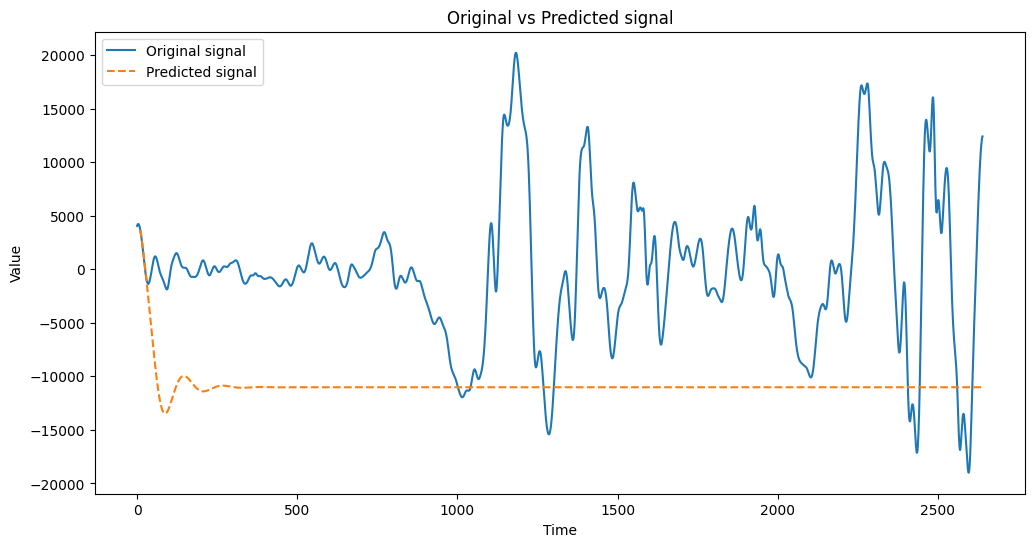

In [207]:
# Исходный ряд 
original = possible_cycle_filtered.values if hasattr(possible_cycle_filtered, 'values') else possible_cycle_filtered

# Длина окна для предсказаний (seq_length)
seq_length = 10

# Создаем ось времени для исходного ряда
time_original = np.arange(len(original))

# Создаем ось времени для предсказаний
# Поскольку предсказаний меньше на seq_length (из-за окна), сдвигаем по времени
time_pred = np.arange(seq_length, seq_length + len(pred_inv))

plt.figure(figsize=(12,6))
plt.plot(time_original, original, label='Original signal')
plt.plot(time_pred, pred_inv, label='Predicted signal', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.title('Original vs Predicted signal')
plt.show()

In [211]:
# 2. Нормализация ряда
scaler2 = MinMaxScaler(feature_range=(-1, 1))
series_norm2 = scaler2.fit_transform(btc_filtered.reshape(-1, 1)).flatten()


# 3. Подготовка данных: формируем пары (X, y) с окном size=10
def create_sequences(data, seq_length=10):
    xs, ys = [], []
    for i in range(len(data)-seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 10
X, y = create_sequences(series_norm, seq_length)

# Конвертация в тензоры для PyTorch
X_t = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)  # (batch, seq_len, input_size=1)
y_t = torch.tensor(y, dtype=torch.float32).unsqueeze(-1)  # (batch, output_size=1)

# 4. Определение модели LSTM
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=1, output_size=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # берем выход последнего шага
        out = self.linear(out)
        return out

model2 = LSTMModel()

# 5. Настройка оптимизатора и функции ошибки
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model2.parameters(), lr=0.01)

# 6. Обучение модели
epochs = 300
for epoch in range(epochs):
    model2.train()
    optimizer.zero_grad()
    output = model2(X_t)
    loss = criterion(output, y_t)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}')

# 7. Прогноз на весь ряд (рекурсивно)
model2.eval()
predictions = []
input_seq = X_t[0].unsqueeze(0)  # берем первый пример (batch=1)
for _ in range(len(series_norm) - seq_length):
    with torch.no_grad():
        pred = model2(input_seq)  # pred.shape = [batch, output_size] = [1,1]
        predictions.append(pred.item())
        pred = pred.unsqueeze(1)  # теперь shape [1,1,1]
        new_seq = torch.cat((input_seq[:,1:,:], pred), dim=1)
        input_seq = new_seq

# 8. Обратное преобразование масштаба
pred_inv2 = scaler2.inverse_transform(np.array(predictions).reshape(-1,1)).flatten()


Epoch 10/300, Loss: 0.021868
Epoch 20/300, Loss: 0.006819
Epoch 30/300, Loss: 0.004340
Epoch 40/300, Loss: 0.003589
Epoch 50/300, Loss: 0.002711
Epoch 60/300, Loss: 0.001975
Epoch 70/300, Loss: 0.001473
Epoch 80/300, Loss: 0.001025
Epoch 90/300, Loss: 0.000635
Epoch 100/300, Loss: 0.000400
Epoch 110/300, Loss: 0.000356
Epoch 120/300, Loss: 0.000311
Epoch 130/300, Loss: 0.000298
Epoch 140/300, Loss: 0.000284
Epoch 150/300, Loss: 0.000274
Epoch 160/300, Loss: 0.000263
Epoch 170/300, Loss: 0.000253
Epoch 180/300, Loss: 0.000243
Epoch 190/300, Loss: 0.000233
Epoch 200/300, Loss: 0.000222
Epoch 210/300, Loss: 0.000212
Epoch 220/300, Loss: 0.000201
Epoch 230/300, Loss: 0.000190
Epoch 240/300, Loss: 0.000178
Epoch 250/300, Loss: 0.000166
Epoch 260/300, Loss: 0.000154
Epoch 270/300, Loss: 0.000141
Epoch 280/300, Loss: 0.000128
Epoch 290/300, Loss: 0.000116
Epoch 300/300, Loss: 0.000105


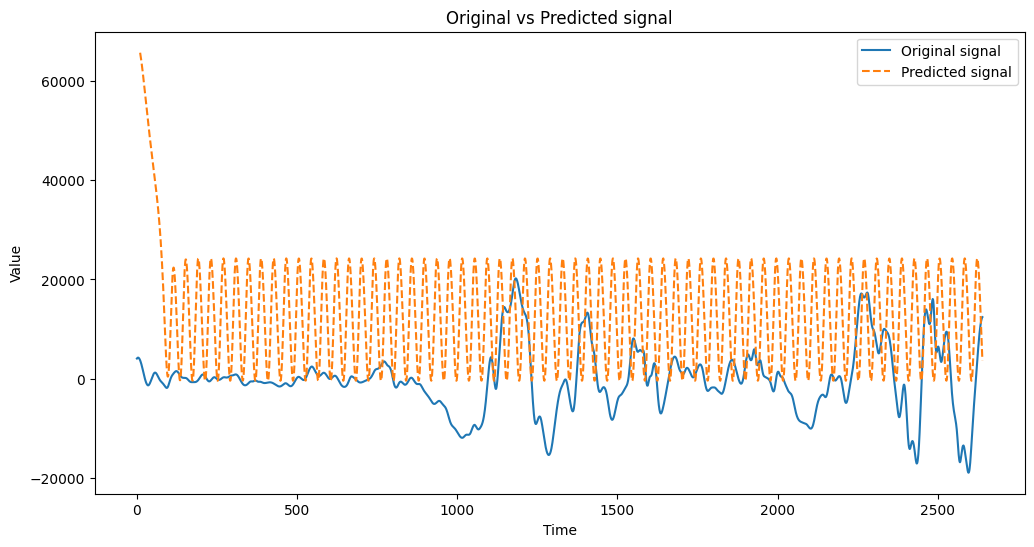

In [212]:
# Длина окна для предсказаний (seq_length)
seq_length = 10

# Создаем ось времени для исходного ряда
time_original = np.arange(len(original))

# Создаем ось времени для предсказаний
# Поскольку предсказаний меньше на seq_length (из-за окна), сдвигаем по времени
time_pred = np.arange(seq_length, seq_length + len(pred_inv2))

plt.figure(figsize=(12,6))
plt.plot(time_original, original, label='Original signal')
plt.plot(time_pred, pred_inv2, label='Predicted signal', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.title('Original vs Predicted signal')
plt.show()